In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_theme(context='notebook', style='darkgrid', palette='deep')

In [3]:
cdl_names = pd.read_csv("../data/cdl_codes.csv", low_memory=False, index_col='Codes')['Class_Names']

In [183]:
kcp = pd.read_csv("../data/1993 NEH Kcp.csv")
kcp

,crop,cdl_code,kcp
0,Alfalfa,36,1.05
1,Grass/Pasture,176,1.05
2,Fallow/Idle Cropland,61,1.00
3,Shrubland,152,1.00
4,Other Hay/Non Alfalfa,37,1.05
5,Pecans,74,1.15
6,Herbaceous Wetlands,195,1.00
7,Dbl Crop Corn/Soybeans,241,1.15
8,Citrus,72,0.70
9,Almonds,75,1.15


In [4]:
visual_month_start = 4
visual_month_end = 8

## Gallatin: Upper Missouri (10020008)

In [98]:
gum_metadata = pd.read_csv("../data/huc8/10020008_metadata.csv", low_memory=False, index_col=0)[['field_id', 'crop_2022', 'hectares']]
gum_metadata.set_index('field_id', inplace=True)

In [99]:
gum_etofs = pd.read_csv("../data/huc8/10020008_values.csv", low_memory=False, index_col=0)
gum_etofs['time'] = pd.to_datetime(gum_etofs['time'])
gum_etofs.set_index('field_id', inplace=True)
gum_etofs = gum_etofs.join(gum_metadata, on='field_id', how='left', validate='many_to_one')
gum_etofs = gum_etofs.join(cdl_names, on='crop_2022')

In [100]:
gum_time_mask = (gum_etofs['time'].dt.month >= visual_month_start) & (gum_etofs['time'].dt.month <= visual_month_end)
gum_summer_maxes = gum_etofs[gum_time_mask].groupby(['field_id', 'collection', 'crop_2022', 'Class_Names', 'hectares'])['value_mm'].agg('max')
gum_summer_maxes = gum_summer_maxes.reset_index()
gum_summer_maxes

,field_id,collection,crop_2022,Class_Names,hectares,value_mm
0,3024838,disalexi_etof,176,Grass/Pasture,4.261,0.761
1,3024838,eemetric_etof,176,Grass/Pasture,4.261,0.749
2,3024838,ensemble_etof,176,Grass/Pasture,4.261,0.745
3,3024838,geesebal_etof,176,Grass/Pasture,4.261,0.813
4,3024838,ptjpl_etof,176,Grass/Pasture,4.261,0.802
...,...,...,...,...,...,...
17747,3061827,ensemble_etof,176,Grass/Pasture,9.002,0.934
17748,3061827,geesebal_etof,176,Grass/Pasture,9.002,1.046
17749,3061827,ptjpl_etof,176,Grass/Pasture,9.002,0.874
17750,3061827,sims_etof,176,Grass/Pasture,9.002,1.066


In [208]:
gum_summer_maxes.groupby(['Class_Names', 'collection'])['value_mm'].describe().round(2)[['mean', 'std', 'max']]

mean   std   max
Class_Names          collection                     
Alfalfa              disalexi_etof  0.95  0.11  1.40
                     eemetric_etof  0.99  0.12  1.22
                     ensemble_etof  0.96  0.09  1.14
                     geesebal_etof  1.12  0.13  1.37
                     ptjpl_etof     0.93  0.07  1.24
                     sims_etof      1.03  0.06  1.12
                     ssebop_etof    0.94  0.14  1.17
Fallow/Idle Cropland disalexi_etof  0.79  0.16  1.23
                     eemetric_etof  0.66  0.19  1.07
                     ensemble_etof  0.74  0.13  1.03
                     geesebal_etof  0.91  0.24  1.40
                     ptjpl_etof     0.82  0.10  1.16
                     sims_etof      0.84  0.11  1.07
                     ssebop_etof    0.48  0.19  1.08
Grass/Pasture        disalexi_etof  0.90  0.11  1.22
                     eemetric_etof  0.87  0.19  1.26
                     ensemble_etof  0.86  0.12  1.12
                     geesebal_etof  1.05  0.17  1.35
                     ptjpl_etof     0.83  0.06  1.05
                     sims_etof      0.99  0.07  1.11
                     ssebop_etof    0.83  0.17  1.18

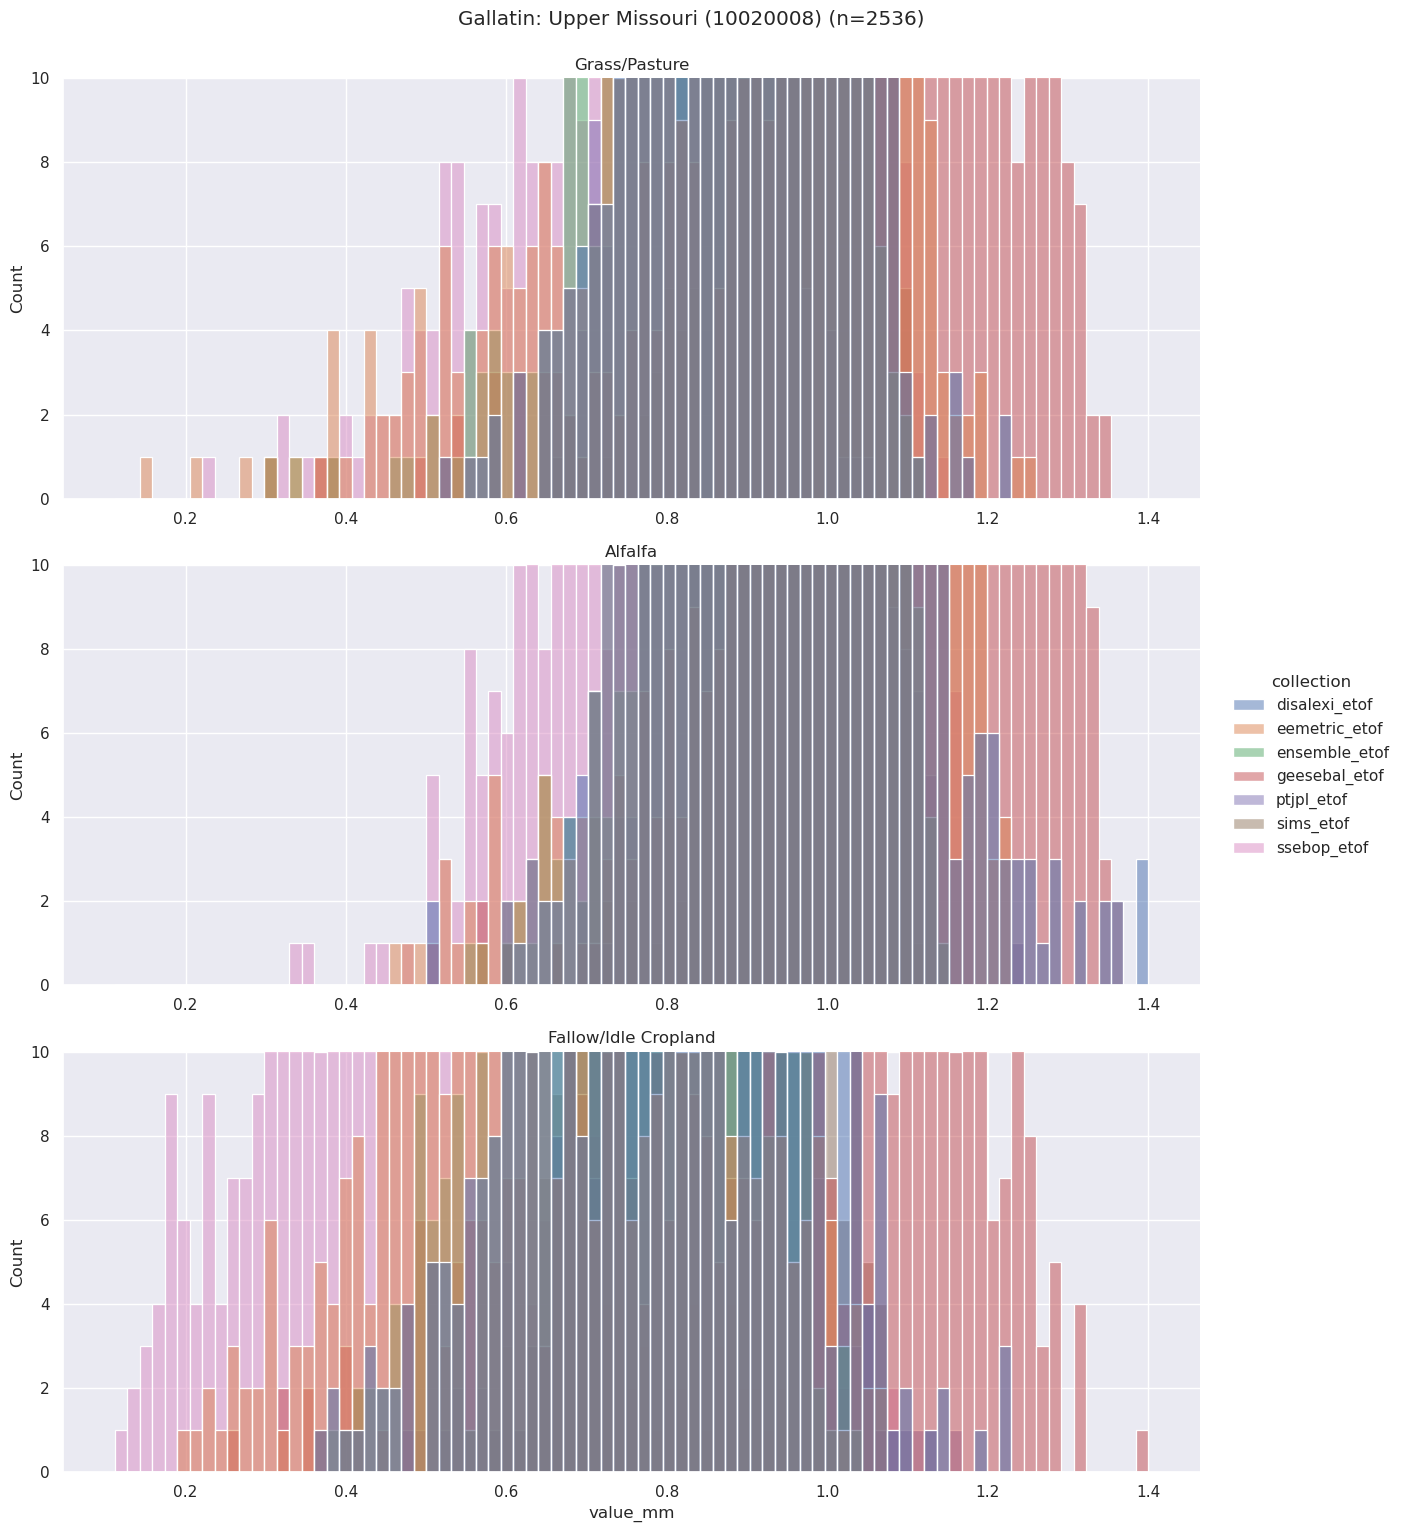

In [209]:
dis = sns.displot(gum_summer_maxes, x='value_mm', row='Class_Names', hue='collection',
                  aspect=2.5, facet_kws={'sharex': False, 'sharey': False});

for ax in dis.axes.flat:
    ax.set_ylim(0, 10)

dis.set_titles(col_template="{col_name}", row_template="{row_name}");
plt.suptitle("Gallatin: Upper Missouri (10020008)" + f" (n={gum_summer_maxes['field_id'].nunique()})", y=1.02);
dis.savefig("../images/huc8/Gallatin Upper Missouri.png")

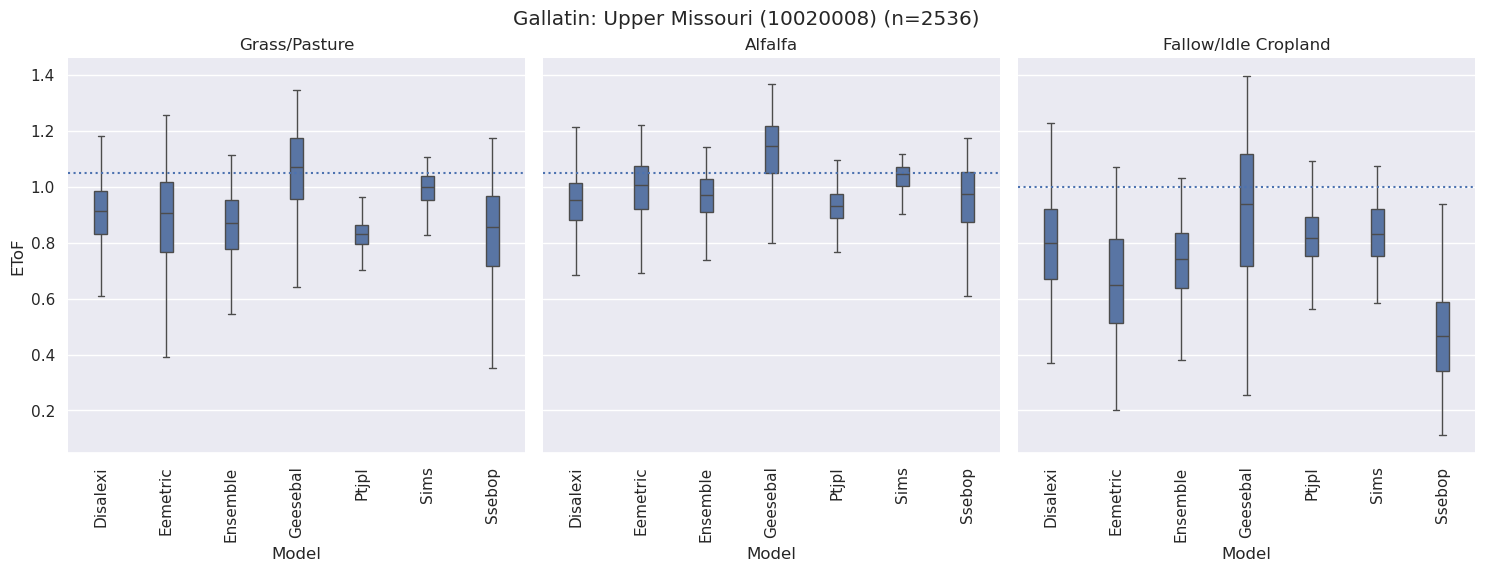

In [193]:
g = sns.catplot(gum_summer_maxes, kind='box', x='collection', y='value_mm', col='Class_Names', 
                estimator='mean', errorbar=('sd', 1),
                formatter=lambda x: x.split('_')[0].capitalize(),
                showfliers=False, width=0.2);

for (row, col, hue), data in g.facet_data():
    kcp_val = kcp[kcp['crop'] == data['Class_Names'].unique()[0]].kcp.values[0]
    ax = g.facet_axis(row, col)
    ax.axhline(y=kcp_val, linestyle='dotted')

g.set_ylabels("EToF")
g.set_xlabels("Model")
g.despine(left=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}");
g.tick_params(axis='x', rotation=90);
plt.suptitle("Gallatin: Upper Missouri (10020008)" + f" (n={summer_maxes['field_id'].nunique()})", y=1.02);
g.savefig('../images/huc8/Boxplot_Gallatin Upper Missouri.png')

## Flathead Lake: Clark-fork (17010208)

In [104]:
flcf_metadata = pd.read_csv("../data/huc8/17010208_metadata.csv", low_memory=False, index_col=0)[['field_id', 'crop_2022', 'hectares']]
flcf_metadata.set_index('field_id', inplace=True)
flcf_metadata.head()

,crop_2022,hectares
field_id,,
3010000,47,47.286
3010001,36,22.674
3010003,47,93.424
3010006,176,8.117
3010008,152,20.449


In [106]:
flcf_etofs = pd.read_csv("../data/huc8/17010208_values.csv", low_memory=False, index_col=0)
flcf_etofs['time'] = pd.to_datetime(flcf_etofs['time'])
flcf_etofs.set_index('field_id', inplace=True)
flcf_etofs = flcf_etofs.join(flcf_metadata, on='field_id', how='left', validate='many_to_one')
flcf_etofs = flcf_etofs.join(cdl_names, on='crop_2022')

In [107]:
flcf_time_mask = (flcf_etofs['time'].dt.month >= visual_month_start) & (flcf_etofs['time'].dt.month <= visual_month_end)
flcf_summer_maxes = flcf_etofs[flcf_time_mask].groupby(['field_id', 'collection', 'crop_2022', 'Class_Names', 'hectares'])['value_mm'].agg('max')
flcf_summer_maxes = flcf_summer_maxes.reset_index()

In [108]:
flcf_summer_maxes.groupby(['Class_Names', 'collection'])['value_mm'].describe().round(2)[['mean', 'std']]

mean   std
Class_Names   collection               
Alfalfa       disalexi_etof  0.96  0.18
              eemetric_etof  0.99  0.14
              ensemble_etof  0.92  0.10
              geesebal_etof  1.06  0.21
              ptjpl_etof     0.99  0.08
              sims_etof      1.02  0.05
              ssebop_etof    0.87  0.14
Grass/Pasture disalexi_etof  0.85  0.20
              eemetric_etof  0.87  0.17
              ensemble_etof  0.82  0.12
              geesebal_etof  0.91  0.26
              ptjpl_etof     0.94  0.10
              sims_etof      0.99  0.07
              ssebop_etof    0.75  0.14
Shrubland     disalexi_etof  0.92  0.17
              eemetric_etof  0.95  0.20
              ensemble_etof  0.86  0.13
              geesebal_etof  1.01  0.26
              ptjpl_etof     0.95  0.12
              sims_etof      1.01  0.05
              ssebop_etof    0.87  0.14

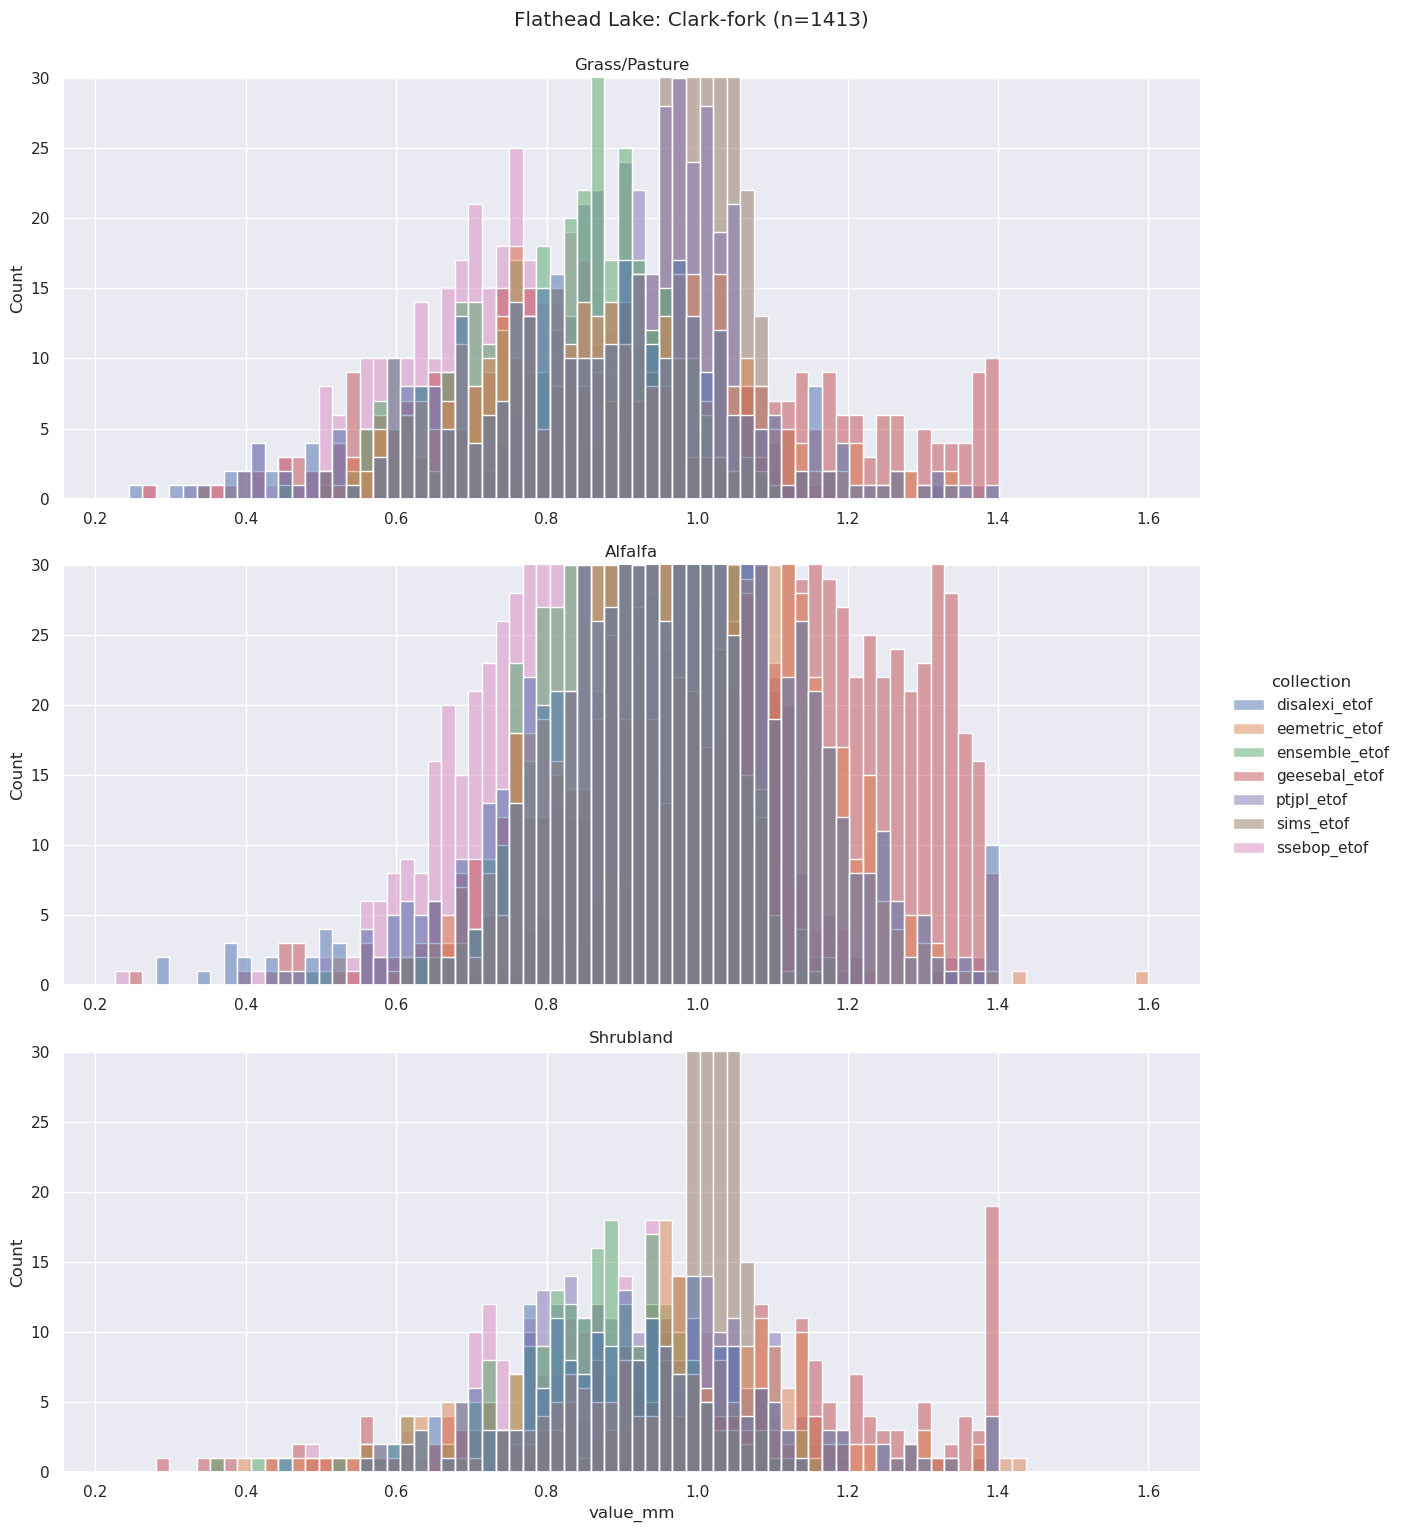

In [109]:
dis = sns.displot(flcf_summer_maxes, x='value_mm', row='Class_Names', hue='collection',
                  aspect=2.5, facet_kws={'sharex': False, 'sharey': False});

for ax in dis.axes.flat:
    ax.set_ylim(0, 30)

dis.set_titles(row_template="{row_name}");
plt.suptitle("Flathead Lake: Clark-fork" + f" (n={flcf_summer_maxes['field_id'].nunique()})", y=1.02);
dis.savefig("../images/huc8/Flathead Lake Clark-fork.png")

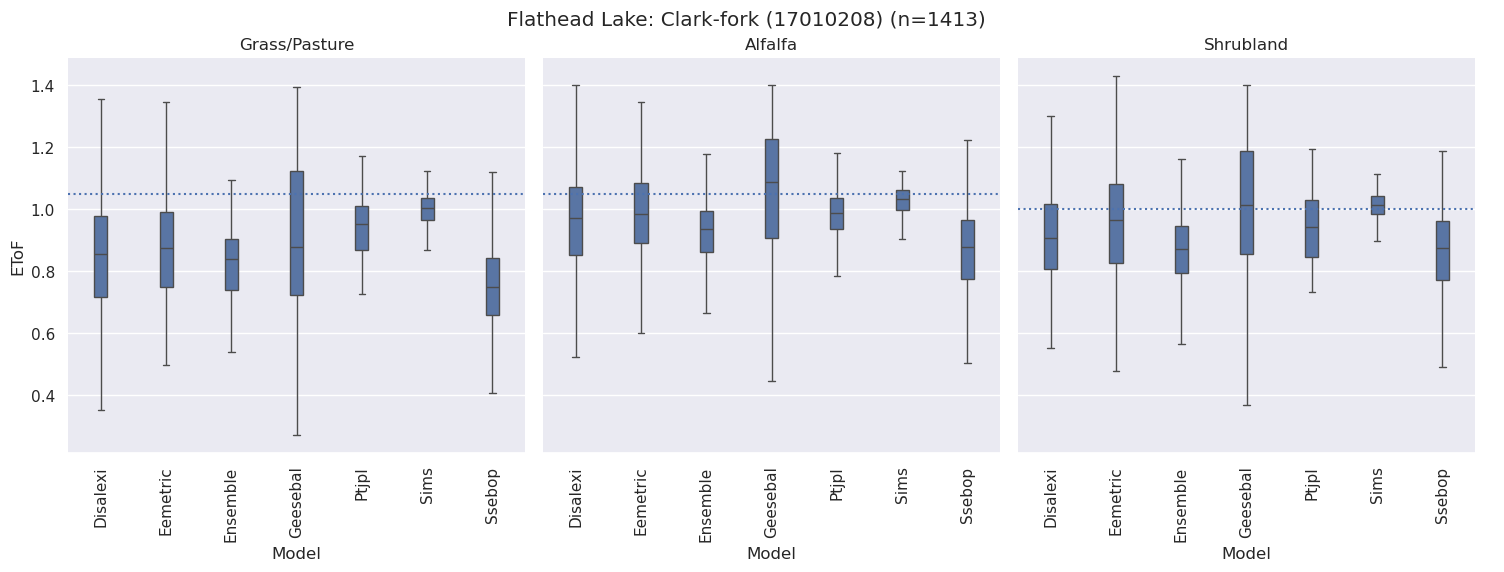

In [194]:
g = sns.catplot(flcf_summer_maxes, kind='box', x='collection', y='value_mm', col='Class_Names', 
                estimator='mean', errorbar=('sd', 1),
                formatter=lambda x: x.split('_')[0].capitalize(),
                showfliers=False, width=0.2);

for (row, col, hue), data in g.facet_data():
    kcp_val = kcp[kcp['crop'] == data['Class_Names'].unique()[0]].kcp.values[0]
    ax = g.facet_axis(row, col)
    ax.axhline(y=kcp_val, linestyle='dotted')

g.set_ylabels("EToF")
g.set_xlabels("Model")
g.despine(left=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}");
g.tick_params(axis='x', rotation=90);
plt.suptitle("Flathead Lake: Clark-fork (17010208)" + f" (n={flcf_summer_maxes['field_id'].nunique()})", y=1.02);

## Cottonwood: Lower Missouri (10050010)

In [112]:
clm_metadata = pd.read_csv("../data/huc8/10050010_metadata.csv", low_memory=False, index_col=0)[['field_id', 'crop_2022', 'hectares']]
clm_metadata.set_index('field_id', inplace=True)

In [113]:
clm_etofs = pd.read_csv("../data/huc8/10050010_values.csv", low_memory=False, index_col=0)
clm_etofs['time'] = pd.to_datetime(clm_etofs['time'])
clm_etofs.set_index('field_id', inplace=True)
clm_etofs = clm_etofs.join(clm_metadata, on='field_id', how='left', validate='many_to_one')
clm_etofs = clm_etofs.join(cdl_names, on='crop_2022')

In [114]:
clm_time_mask = (clm_etofs['time'].dt.month >= visual_month_start) & (clm_etofs['time'].dt.month <= visual_month_end)
clm_summer_maxes = clm_etofs[clm_time_mask].groupby(['field_id', 'collection', 'crop_2022', 'Class_Names', 'hectares'])['value_mm'].agg('max')
clm_summer_maxes = clm_summer_maxes.reset_index()

In [115]:
clm_summer_maxes.groupby(['Class_Names', 'collection'])['value_mm'].describe().round(2)[['mean', 'std']]

mean   std
Class_Names           collection               
Alfalfa               disalexi_etof  0.60  0.16
                      eemetric_etof  0.52  0.22
                      ensemble_etof  0.56  0.16
                      geesebal_etof  0.71  0.19
                      ptjpl_etof     0.72  0.09
                      sims_etof      0.81  0.10
                      ssebop_etof    0.46  0.20
Grass/Pasture         disalexi_etof  0.65  0.12
                      eemetric_etof  0.48  0.15
                      ensemble_etof  0.51  0.10
                      geesebal_etof  0.79  0.19
                      ptjpl_etof     0.65  0.07
                      sims_etof      0.70  0.09
                      ssebop_etof    0.44  0.13
Other Hay/Non Alfalfa disalexi_etof  0.67  0.18
                      eemetric_etof  0.53  0.18
                      ensemble_etof  0.55  0.12
                      geesebal_etof  0.78  0.21
                      ptjpl_etof     0.71  0.09
                      sims_etof      0.78  0.08
                      ssebop_etof    0.44  0.15

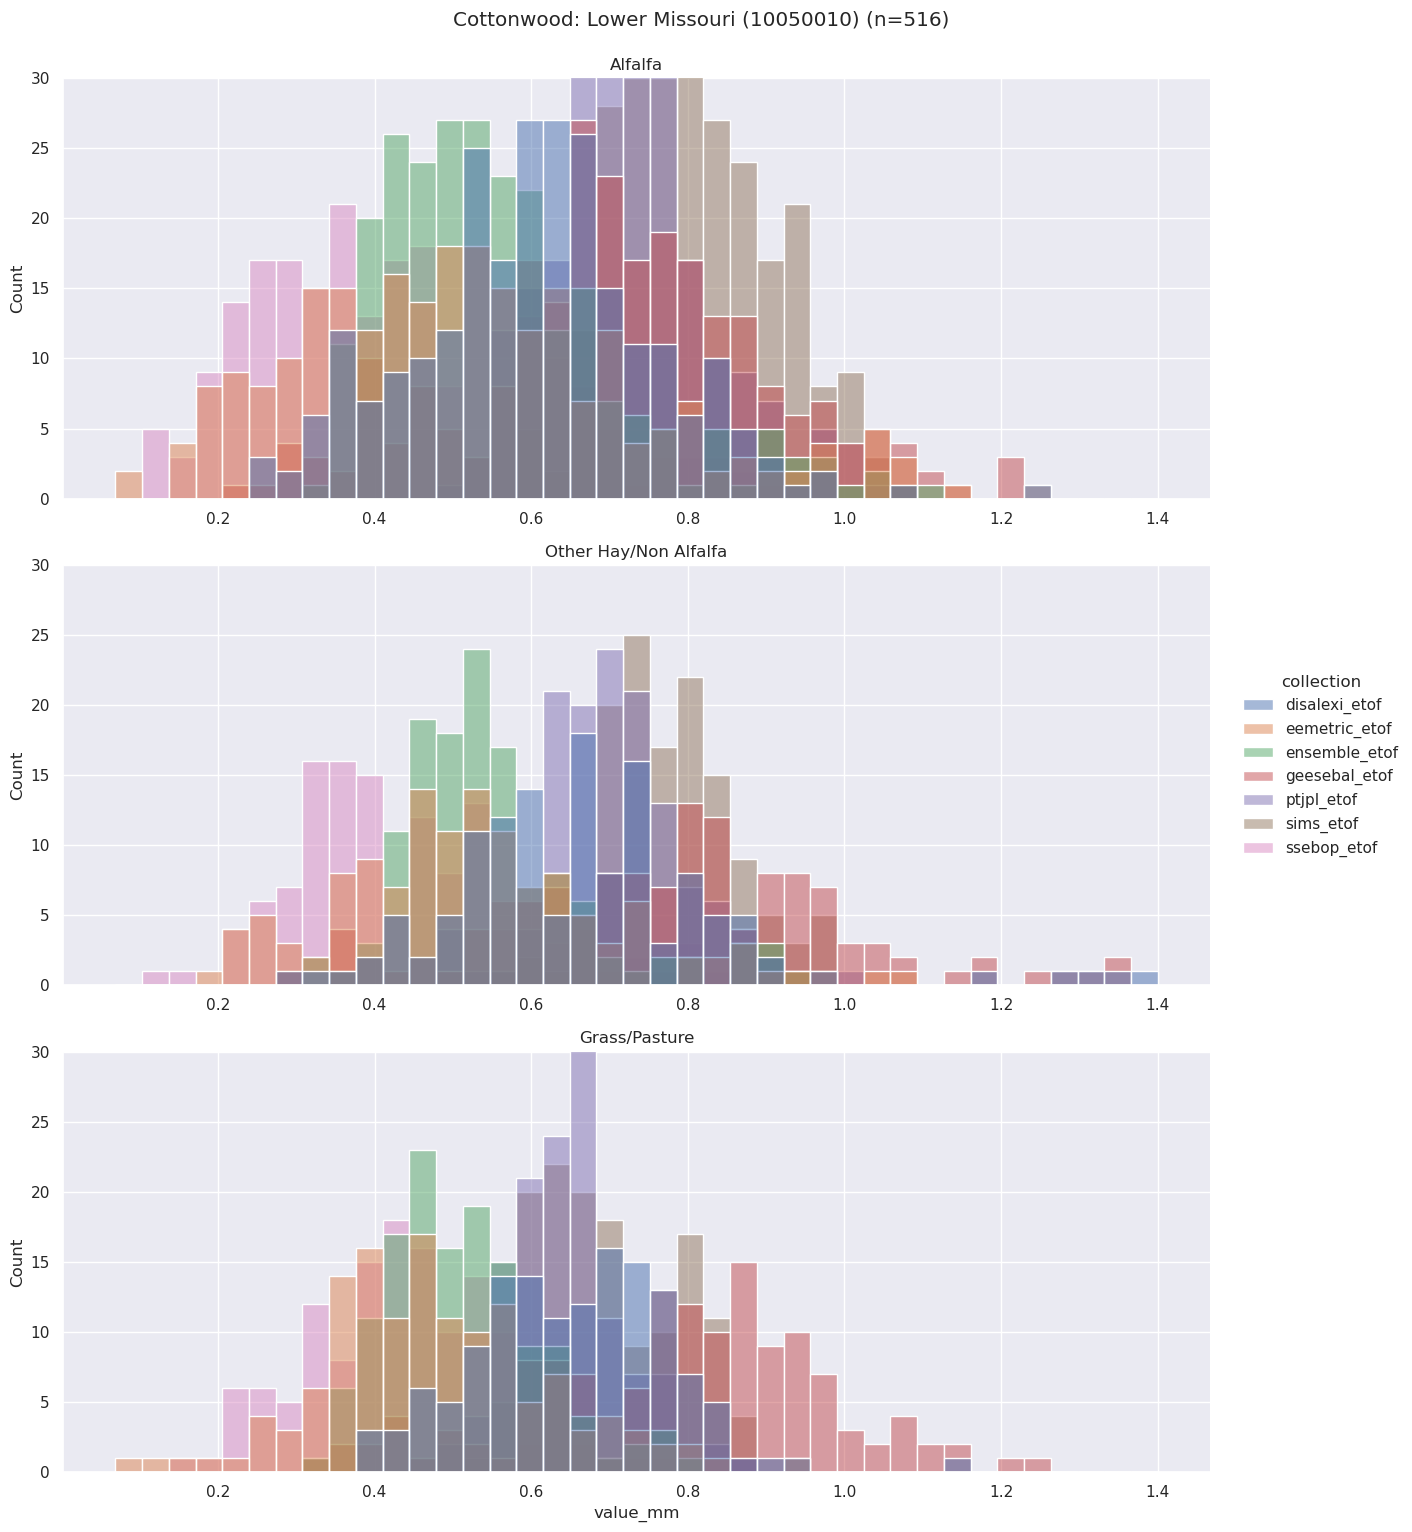

In [116]:
dis = sns.displot(clm_summer_maxes, x='value_mm', row='Class_Names', hue='collection',
                  aspect=2.5, facet_kws={'sharex': False, 'sharey': False});

for ax in dis.axes.flat:
    ax.set_ylim(0, 30)

dis.set_titles(row_template="{row_name}");
plt.suptitle("Cottonwood: Lower Missouri (10050010)" + f" (n={clm_summer_maxes['field_id'].nunique()})", y=1.02);
dis.savefig("../images/huc8/Cottonwood Lower Missouri.png")

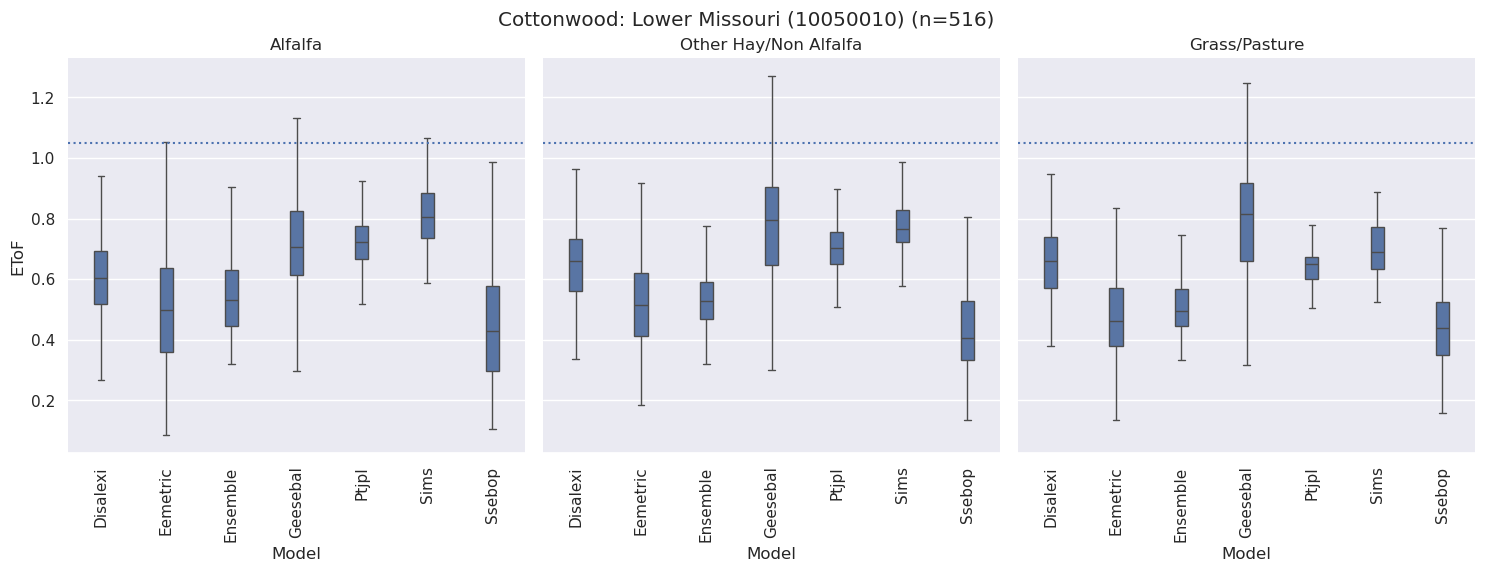

In [195]:
g = sns.catplot(clm_summer_maxes, kind='box', x='collection', y='value_mm', col='Class_Names', 
                estimator='mean', errorbar=('sd', 1),
                formatter=lambda x: x.split('_')[0].capitalize(),
                showfliers=False, width=0.2);

for (row, col, hue), data in g.facet_data():
    kcp_val = kcp[kcp['crop'] == data['Class_Names'].unique()[0]].kcp.values[0]
    ax = g.facet_axis(row, col)
    ax.axhline(y=kcp_val, linestyle='dotted')

g.set_ylabels("EToF")
g.set_xlabels("Model")
g.despine(left=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}");
g.tick_params(axis='x', rotation=90);
plt.suptitle("Cottonwood: Lower Missouri (10050010)" + f" (n={clm_summer_maxes['field_id'].nunique()})", y=1.02);

## El-Paso, Las Cruces NM Rio Grande (13030102)

In [118]:
eplc_metadata = pd.read_csv("../data/huc8/13030102_metadata.csv", low_memory=False, index_col=0)[['field_id', 'crop_2022', 'hectares']]
eplc_metadata.set_index('field_id', inplace=True)

In [119]:
eplc_etofs = pd.read_csv("../data/huc8/13030102_values.csv", low_memory=False, index_col=0)
eplc_etofs['time'] = pd.to_datetime(eplc_etofs['time'])
eplc_etofs.set_index('field_id', inplace=True)
eplc_etofs = eplc_etofs.join(eplc_metadata, on='field_id', how='left', validate='many_to_one')
eplc_etofs = eplc_etofs.join(cdl_names, on='crop_2022')

In [120]:
eplc_time_mask = (eplc_etofs['time'].dt.month >= visual_month_start) & (eplc_etofs['time'].dt.month <= visual_month_end)
eplc_summer_maxes = eplc_etofs[eplc_time_mask].groupby(['field_id', 'collection', 'crop_2022', 'Class_Names', 'hectares'])['value_mm'].agg('max')
eplc_summer_maxes = eplc_summer_maxes.reset_index()

In [122]:
eplc_summer_maxes.groupby(['Class_Names', 'collection'])['value_mm'].describe().round(2)[['mean', 'std']]

mean   std
Class_Names          collection               
Alfalfa              disalexi_etof  0.65  0.15
                     eemetric_etof  0.75  0.22
                     ensemble_etof  0.72  0.17
                     geesebal_etof  0.76  0.17
                     ptjpl_etof     0.75  0.18
                     sims_etof      0.86  0.14
                     ssebop_etof    0.64  0.20
Fallow/Idle Cropland disalexi_etof  0.46  0.17
                     eemetric_etof  0.48  0.21
                     ensemble_etof  0.48  0.18
                     geesebal_etof  0.59  0.18
                     ptjpl_etof     0.43  0.19
                     sims_etof      0.60  0.19
                     ssebop_etof    0.41  0.19
Pecans               disalexi_etof  0.73  0.17
                     eemetric_etof  0.69  0.21
                     ensemble_etof  0.77  0.17
                     geesebal_etof  0.82  0.16
                     ptjpl_etof     0.85  0.17
                     sims_etof      0.94  0.13
                     ssebop_etof    0.70  0.23

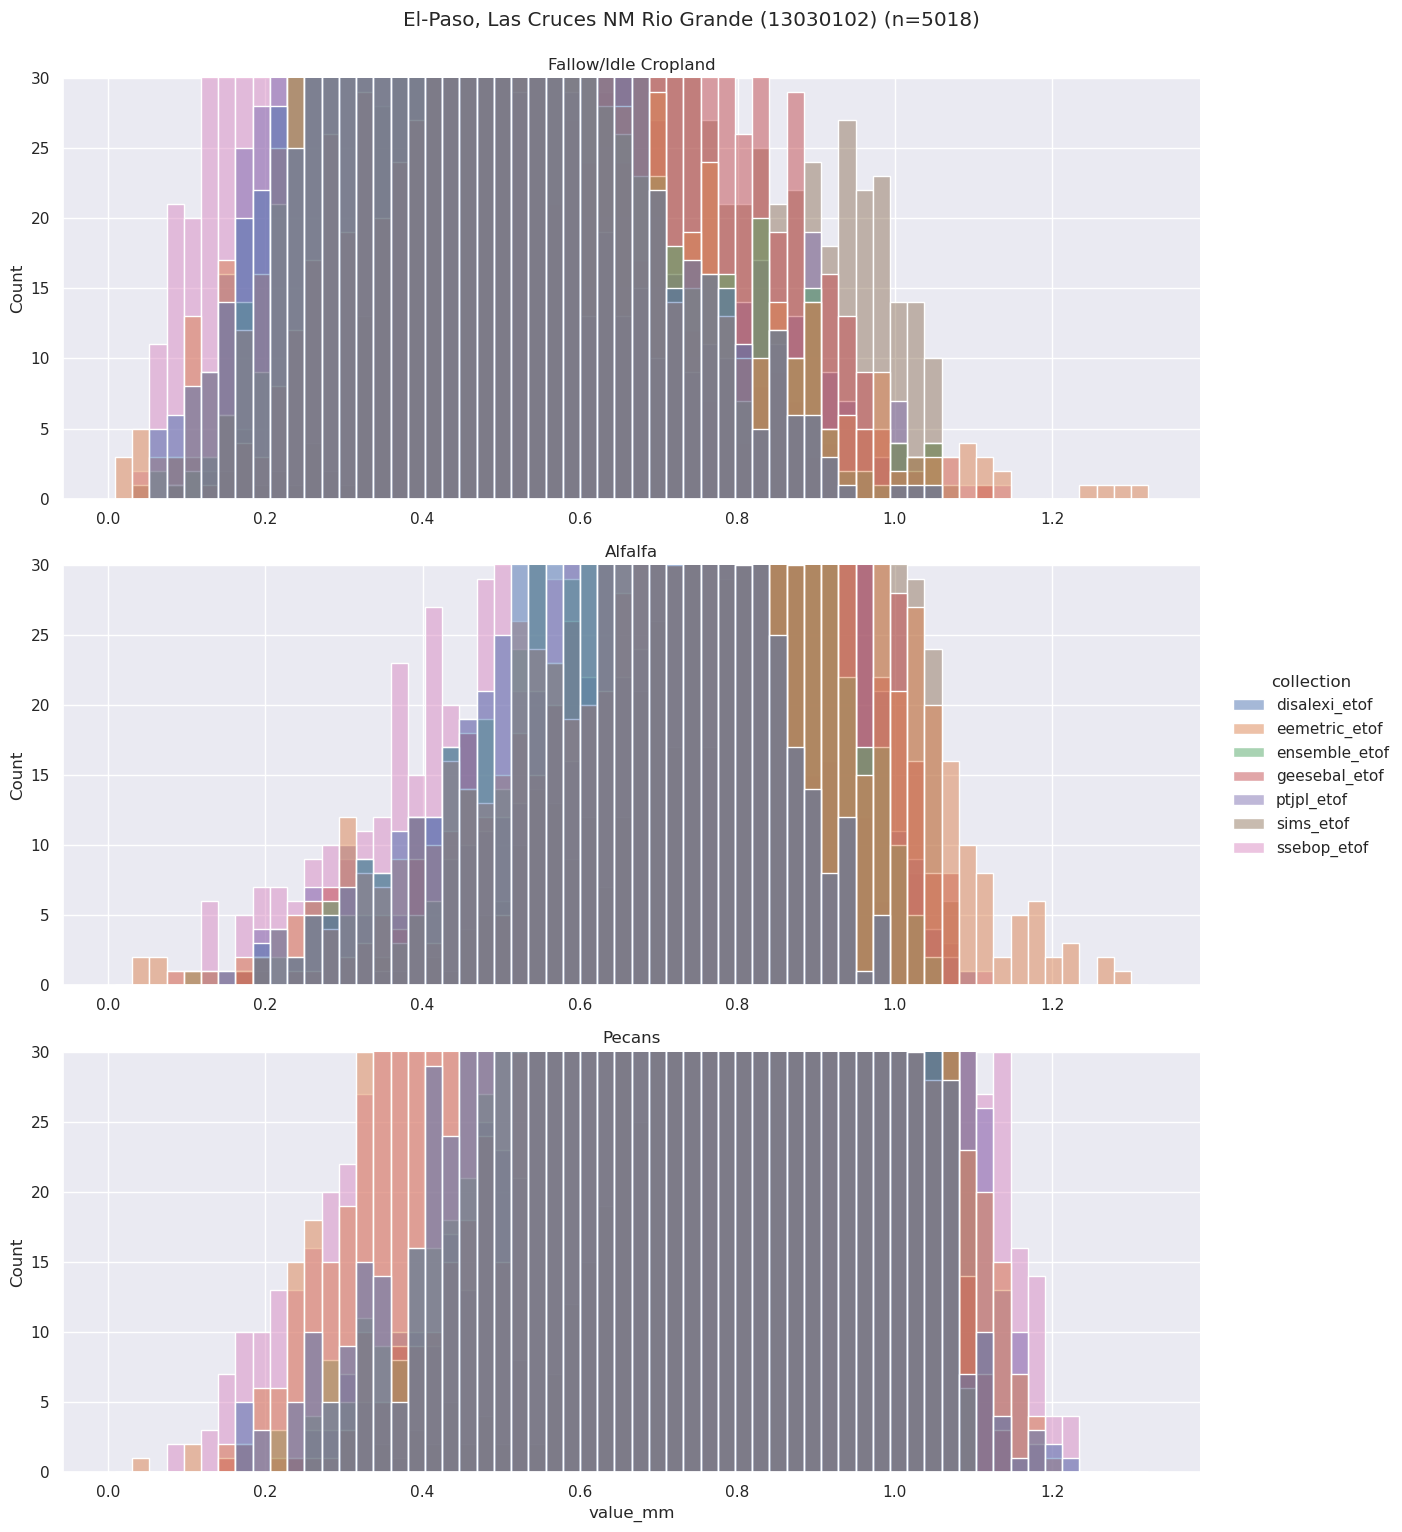

In [123]:
dis = sns.displot(eplc_summer_maxes, x='value_mm', row='Class_Names', hue='collection',
                  aspect=2.5, facet_kws={'sharex': False, 'sharey': False});

for ax in dis.axes.flat:
    ax.set_ylim(0, 30)

dis.set_titles(row_template="{row_name}");
plt.suptitle("El-Paso, Las Cruces NM Rio Grande (13030102)" + f" (n={eplc_summer_maxes['field_id'].nunique()})", y=1.02);
dis.savefig("../images/huc8/El-Paso Las Cruces NM Rio Grande.png")

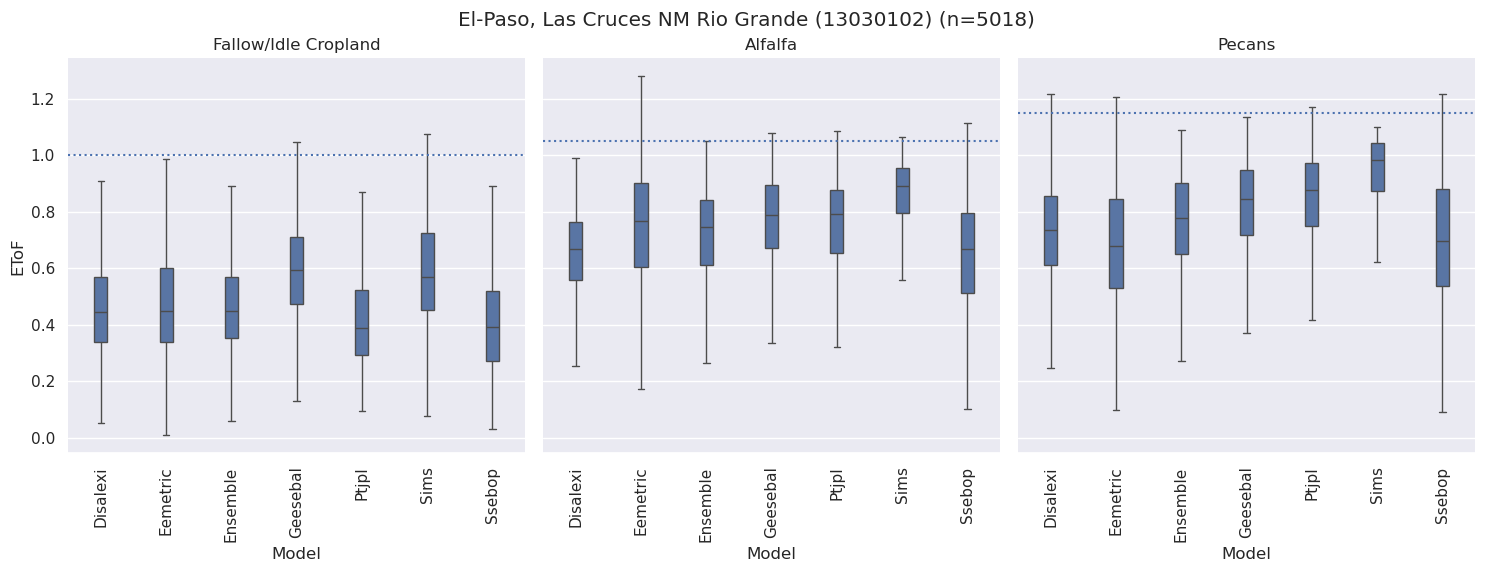

In [196]:
g = sns.catplot(eplc_summer_maxes, kind='box', x='collection', y='value_mm', col='Class_Names', 
                estimator='mean', errorbar=('sd', 1),
                formatter=lambda x: x.split('_')[0].capitalize(),
                showfliers=False, width=0.2);

for (row, col, hue), data in g.facet_data():
    kcp_val = kcp[kcp['crop'] == data['Class_Names'].unique()[0]].kcp.values[0]
    ax = g.facet_axis(row, col)
    ax.axhline(y=kcp_val, linestyle='dotted')

g.set_ylabels("EToF")
g.set_xlabels("Model")
g.despine(left=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}");
g.tick_params(axis='x', rotation=90);
plt.suptitle("El-Paso, Las Cruces NM Rio Grande (13030102)" + f" (n={eplc_summer_maxes['field_id'].nunique()})", y=1.02);

## San Luis Valley Colorado (13010003)

In [125]:
slvc_metadata = pd.read_csv("../data/huc8/13010003_metadata.csv", low_memory=False, index_col=0)[['field_id', 'crop_2022', 'hectares']]
slvc_metadata.set_index('field_id', inplace=True)

In [126]:
slvc_etofs = pd.read_csv("../data/huc8/13010003_values.csv", low_memory=False, index_col=0)
slvc_etofs['time'] = pd.to_datetime(slvc_etofs['time'])
slvc_etofs.set_index('field_id', inplace=True)
slvc_etofs = slvc_etofs.join(slvc_metadata, on='field_id', how='left', validate='many_to_one')
slvc_etofs = slvc_etofs.join(cdl_names, on='crop_2022')

In [129]:
slvc_time_mask = (slvc_etofs['time'].dt.month >= visual_month_start) & (slvc_etofs['time'].dt.month <= visual_month_end)
slvc_summer_maxes = slvc_etofs[slvc_time_mask].groupby(['field_id', 'collection', 'crop_2022', 'Class_Names', 'hectares'])['value_mm'].agg('max')
slvc_summer_maxes = slvc_summer_maxes.reset_index()

In [130]:
slvc_summer_maxes.groupby(['Class_Names', 'collection'])['value_mm'].describe().round(2)[['mean', 'std']]

mean   std
Class_Names         collection               
Alfalfa             disalexi_etof  0.72  0.21
                    eemetric_etof  0.77  0.22
                    ensemble_etof  0.74  0.22
                    geesebal_etof  0.77  0.22
                    ptjpl_etof     0.73  0.19
                    sims_etof      0.89  0.19
                    ssebop_etof    0.68  0.27
Herbaceous Wetlands disalexi_etof  0.48  0.19
                    eemetric_etof  0.52  0.23
                    ensemble_etof  0.52  0.20
                    geesebal_etof  0.59  0.23
                    ptjpl_etof     0.68  0.13
                    sims_etof      0.82  0.11
                    ssebop_etof    0.45  0.19
Shrubland           disalexi_etof  0.47  0.14
                    eemetric_etof  0.43  0.16
                    ensemble_etof  0.44  0.15
                    geesebal_etof  0.60  0.16
                    ptjpl_etof     0.43  0.14
                    sims_etof      0.71  0.14
                    ssebop_etof    0.40  0.16

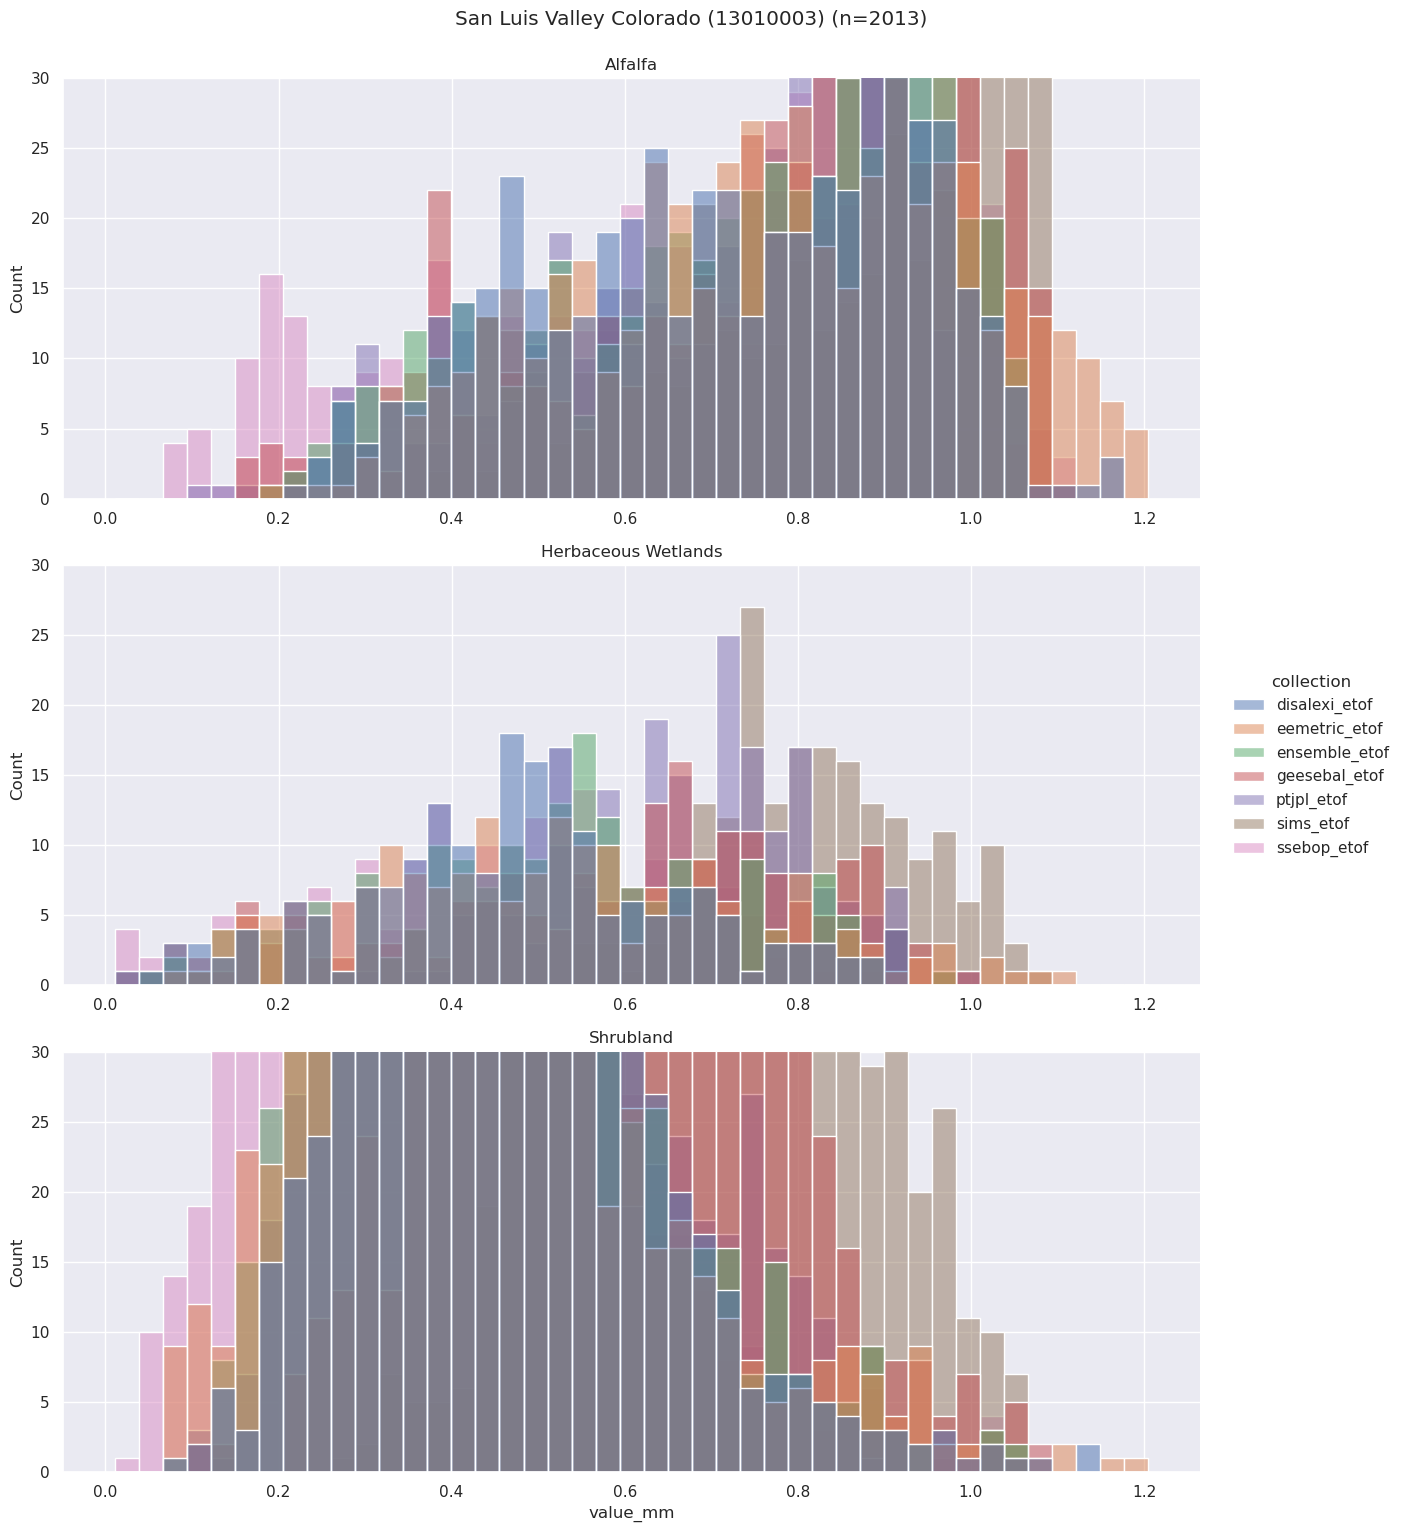

In [131]:
dis = sns.displot(slvc_summer_maxes, x='value_mm', row='Class_Names', hue='collection',
                  aspect=2.5, facet_kws={'sharex': False, 'sharey': False});

for ax in dis.axes.flat:
    ax.set_ylim(0, 30)

dis.set_titles(row_template="{row_name}");
plt.suptitle("San Luis Valley Colorado (13010003)" + f" (n={slvc_summer_maxes['field_id'].nunique()})", y=1.02);
dis.savefig("../images/huc8/San Luis Valley Colorado.png")

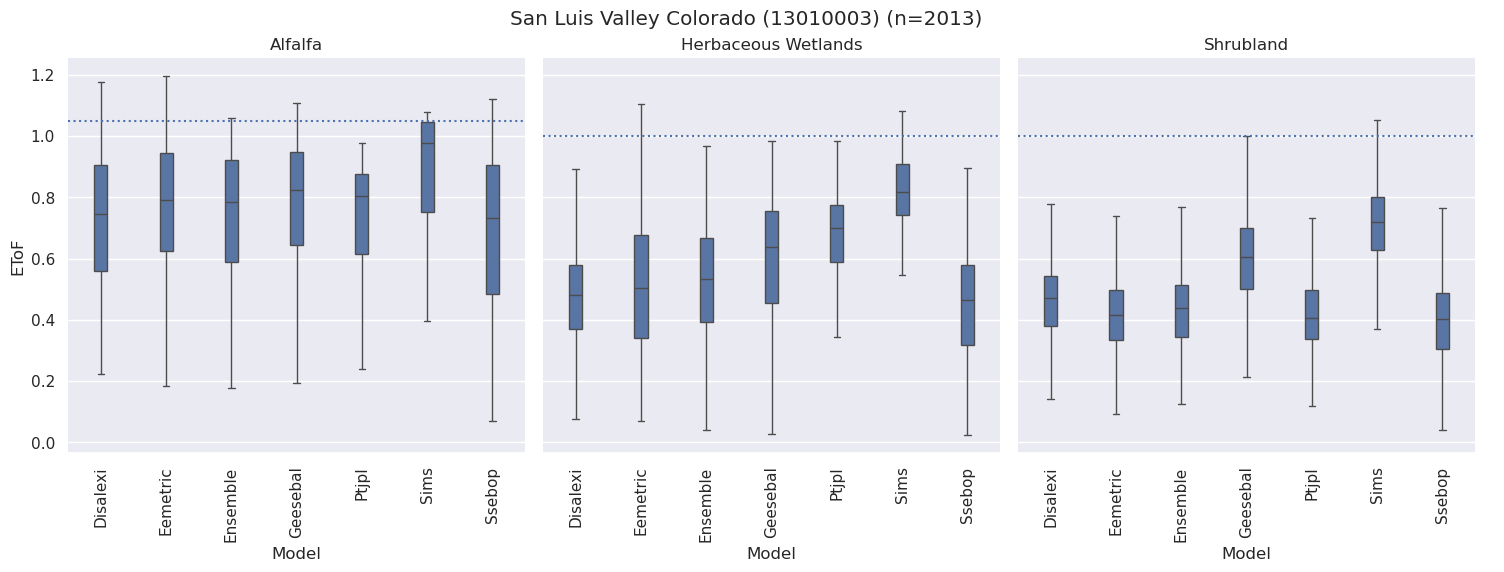

In [197]:
g = sns.catplot(slvc_summer_maxes, kind='box', x='collection', y='value_mm', col='Class_Names', 
                estimator='mean', errorbar=('sd', 1),
                formatter=lambda x: x.split('_')[0].capitalize(),
                showfliers=False, width=0.2);

for (row, col, hue), data in g.facet_data():
    kcp_val = kcp[kcp['crop'] == data['Class_Names'].unique()[0]].kcp.values[0]
    ax = g.facet_axis(row, col)
    ax.axhline(y=kcp_val, linestyle='dotted')

g.set_ylabels("EToF")
g.set_xlabels("Model")

g.despine(left=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}");
g.tick_params(axis='x', rotation=90);
plt.suptitle("San Luis Valley Colorado (13010003)" + f" (n={slvc_summer_maxes['field_id'].nunique()})", y=1.02);

## NW New Mexico Navajo Nation off Reservation Trust Land (14080101)

In [139]:
nmnn_metadata = pd.read_csv("../data/huc8/14080101_metadata.csv", low_memory=False, index_col=0)[['field_id', 'crop_2022', 'hectares']]
nmnn_metadata.set_index('field_id', inplace=True)

In [141]:
nmnn_etofs = pd.read_csv("../data/huc8/14080101_values.csv", low_memory=False, index_col=0)
nmnn_etofs['time'] = pd.to_datetime(nmnn_etofs['time'])
nmnn_etofs.set_index('field_id', inplace=True)
nmnn_etofs = nmnn_etofs.join(nmnn_metadata, on='field_id', how='left', validate='many_to_one')
nmnn_etofs = nmnn_etofs.join(cdl_names, on='crop_2022')

In [143]:
nmnn_time_mask = (nmnn_etofs['time'].dt.month >= visual_month_start) & (nmnn_etofs['time'].dt.month <= visual_month_end)
nmnn_summer_maxes = nmnn_etofs[nmnn_time_mask].groupby(['field_id', 'collection', 'crop_2022', 'Class_Names', 'hectares'])['value_mm'].agg('max')
nmnn_summer_maxes = nmnn_summer_maxes.reset_index()

In [144]:
nmnn_summer_maxes.groupby(['Class_Names', 'collection'])['value_mm'].describe().round(2)[['mean', 'std']]

mean   std
Class_Names   collection               
Alfalfa       disalexi_etof  0.80  0.22
              eemetric_etof  0.95  0.10
              ensemble_etof  0.93  0.08
              geesebal_etof  0.99  0.08
              ptjpl_etof     0.93  0.06
              sims_etof      1.00  0.07
              ssebop_etof    0.76  0.13
Grass/Pasture disalexi_etof  0.76  0.20
              eemetric_etof  0.97  0.10
              ensemble_etof  0.88  0.06
              geesebal_etof  0.96  0.08
              ptjpl_etof     0.85  0.04
              sims_etof      0.98  0.07
              ssebop_etof    0.72  0.10
Shrubland     disalexi_etof  0.61  0.13
              eemetric_etof  0.88  0.15
              ensemble_etof  0.78  0.10
              geesebal_etof  0.91  0.12
              ptjpl_etof     0.79  0.07
              sims_etof      0.99  0.08
              ssebop_etof    0.67  0.14

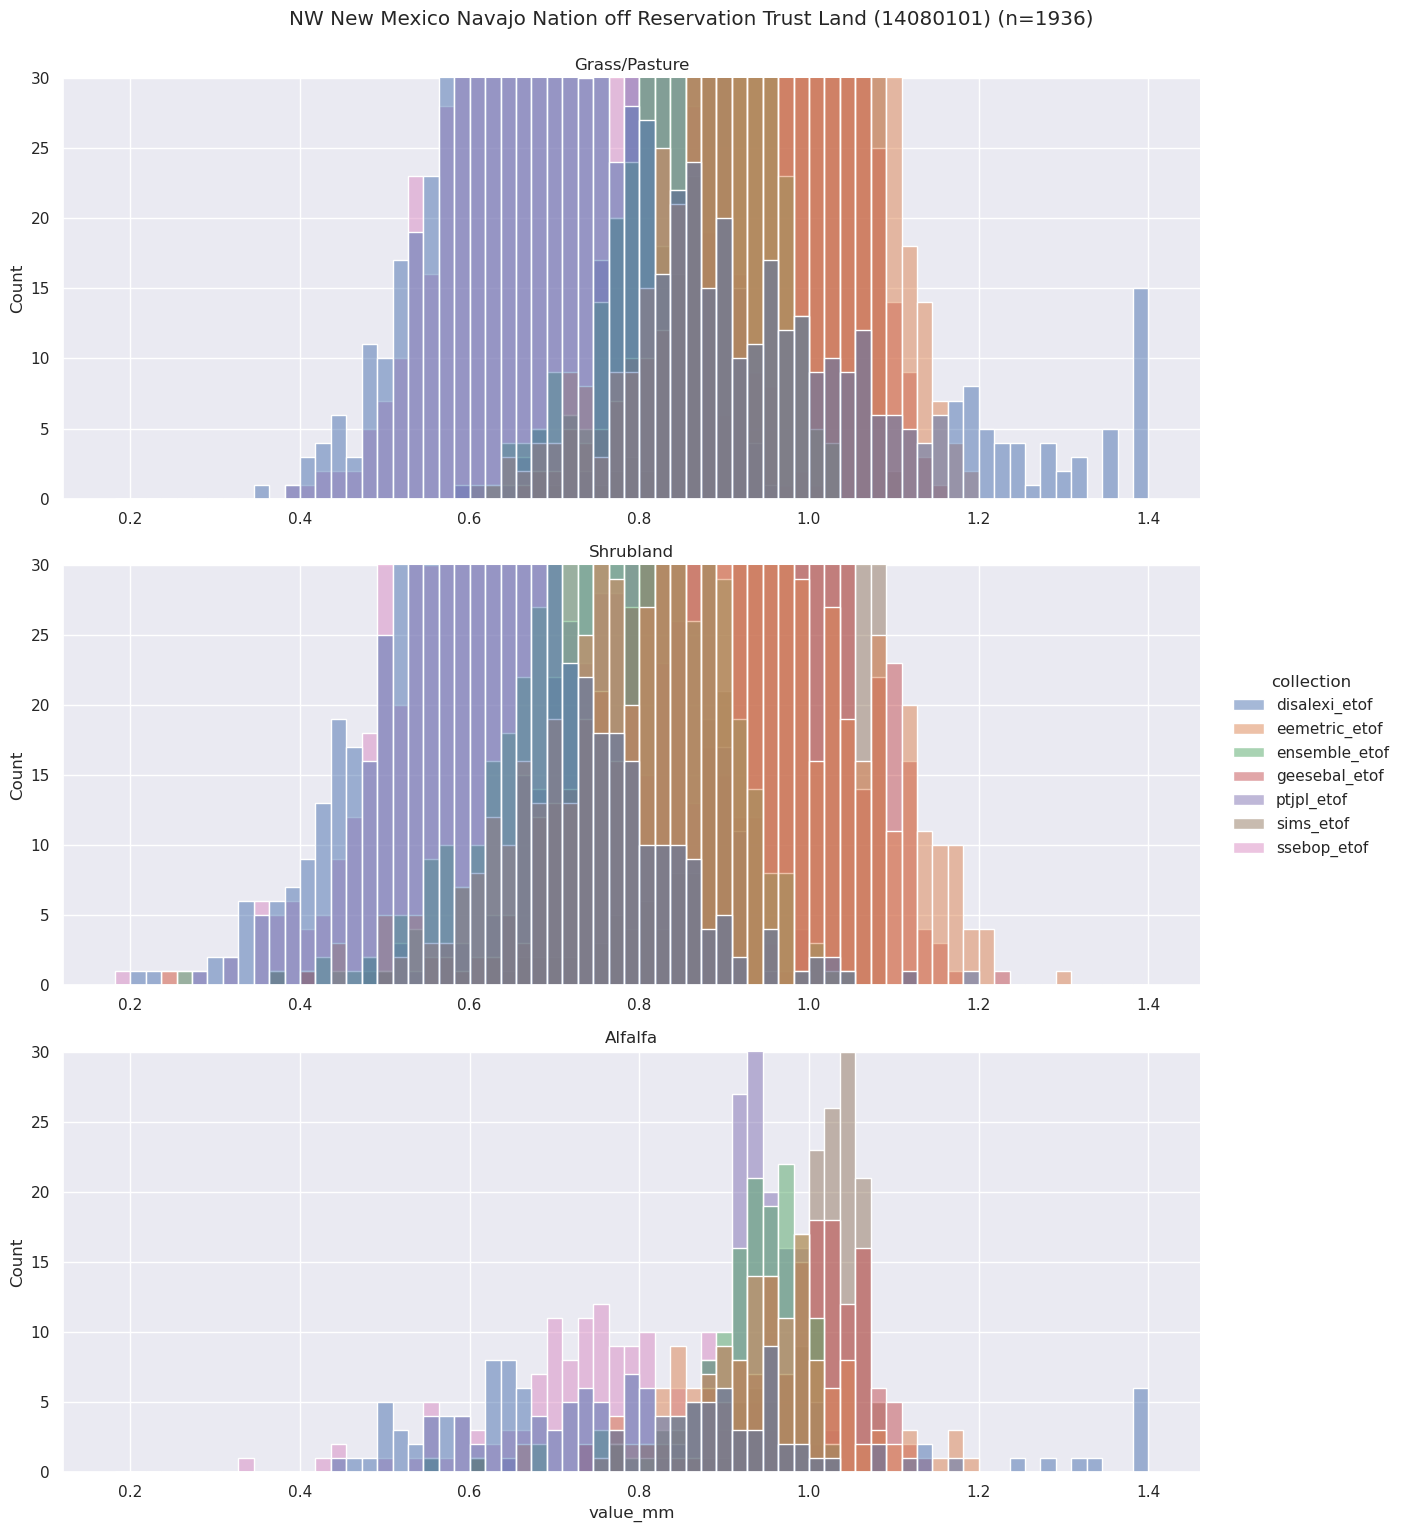

In [145]:
dis = sns.displot(nmnn_summer_maxes, x='value_mm', row='Class_Names', hue='collection',
                  aspect=2.5, facet_kws={'sharex': False, 'sharey': False});

for ax in dis.axes.flat:
    ax.set_ylim(0, 30)

dis.set_titles(row_template="{row_name}");
plt.suptitle("NW New Mexico Navajo Nation off Reservation Trust Land (14080101)" + f" (n={nmnn_summer_maxes['field_id'].nunique()})", y=1.02);
dis.savefig("../images/huc8/NW New Mexico Navajo Nation off Reservation Trust Land.png")

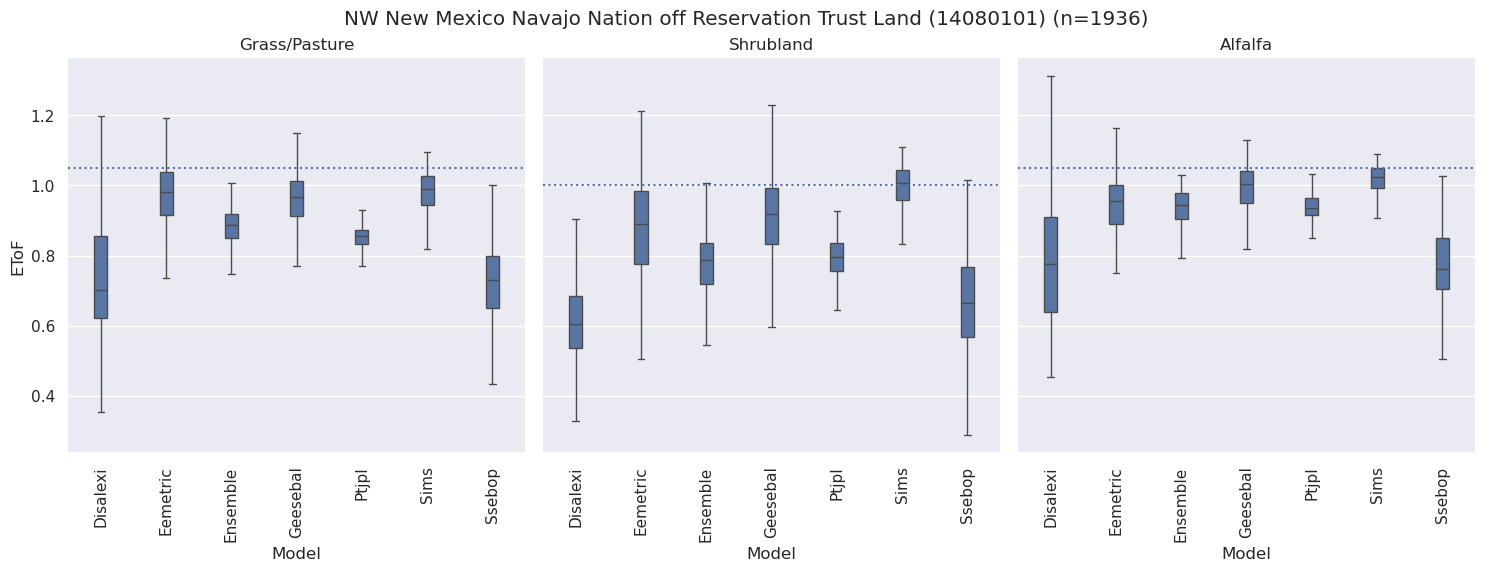

In [198]:
g = sns.catplot(nmnn_summer_maxes, kind='box', x='collection', y='value_mm', col='Class_Names', 
                estimator='mean', errorbar=('sd', 1),
                formatter=lambda x: x.split('_')[0].capitalize(),
                showfliers=False, width=0.2);

for (row, col, hue), data in g.facet_data():
    kcp_val = kcp[kcp['crop'] == data['Class_Names'].unique()[0]].kcp.values[0]
    ax = g.facet_axis(row, col)
    ax.axhline(y=kcp_val, linestyle='dotted')
    
g.set_ylabels("EToF")
g.set_xlabels("Model")
g.despine(left=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}");
g.tick_params(axis='x', rotation=90);
plt.suptitle("NW New Mexico Navajo Nation off Reservation Trust Land (14080101)" + f" (n={nmnn_summer_maxes['field_id'].nunique()})", y=1.02);

## Salton Sea | Imperial Valley (18100204)

In [147]:
ssiv_metadata = pd.read_csv("../data/huc8/18100204_metadata.csv", low_memory=False, index_col=0)[['field_id', 'crop_2022', 'hectares']]
ssiv_metadata.set_index('field_id', inplace=True)

In [149]:
ssiv_etofs = pd.read_csv("../data/huc8/18100204_values.csv", low_memory=False, index_col=0)
ssiv_etofs['time'] = pd.to_datetime(ssiv_etofs['time'])
ssiv_etofs.set_index('field_id', inplace=True)
ssiv_etofs = ssiv_etofs.join(ssiv_metadata, on='field_id', how='left', validate='many_to_one')
ssiv_etofs = ssiv_etofs.join(cdl_names, on='crop_2022')

In [152]:
ssiv_time_mask = (ssiv_etofs['time'].dt.month >= visual_month_start) & (ssiv_etofs['time'].dt.month <= visual_month_end)
ssiv_summer_maxes = ssiv_etofs[ssiv_time_mask].groupby(['field_id', 'collection', 'crop_2022', 'Class_Names', 'hectares'])['value_mm'].agg('max')
ssiv_summer_maxes = ssiv_summer_maxes.reset_index()

In [151]:
ssiv_summer_maxes.groupby(['Class_Names', 'collection'])['value_mm'].describe().round(2)[['mean', 'std']]

mean   std
Class_Names          collection               
Alfalfa              disalexi_etof  0.75  0.13
                     eemetric_etof  0.88  0.16
                     ensemble_etof  0.80  0.15
                     geesebal_etof  0.70  0.12
                     ptjpl_etof     0.82  0.17
                     sims_etof      0.84  0.16
                     ssebop_etof    0.82  0.18
Fallow/Idle Cropland disalexi_etof  0.45  0.25
                     eemetric_etof  0.53  0.30
                     ensemble_etof  0.42  0.29
                     geesebal_etof  0.45  0.22
                     ptjpl_etof     0.29  0.22
                     sims_etof      0.40  0.37
                     ssebop_etof    0.42  0.33
Grass/Pasture        disalexi_etof  0.71  0.14
                     eemetric_etof  0.77  0.20
                     ensemble_etof  0.70  0.17
                     geesebal_etof  0.66  0.13
                     ptjpl_etof     0.53  0.13
                     sims_etof      0.80  0.22
                     ssebop_etof    0.75  0.21

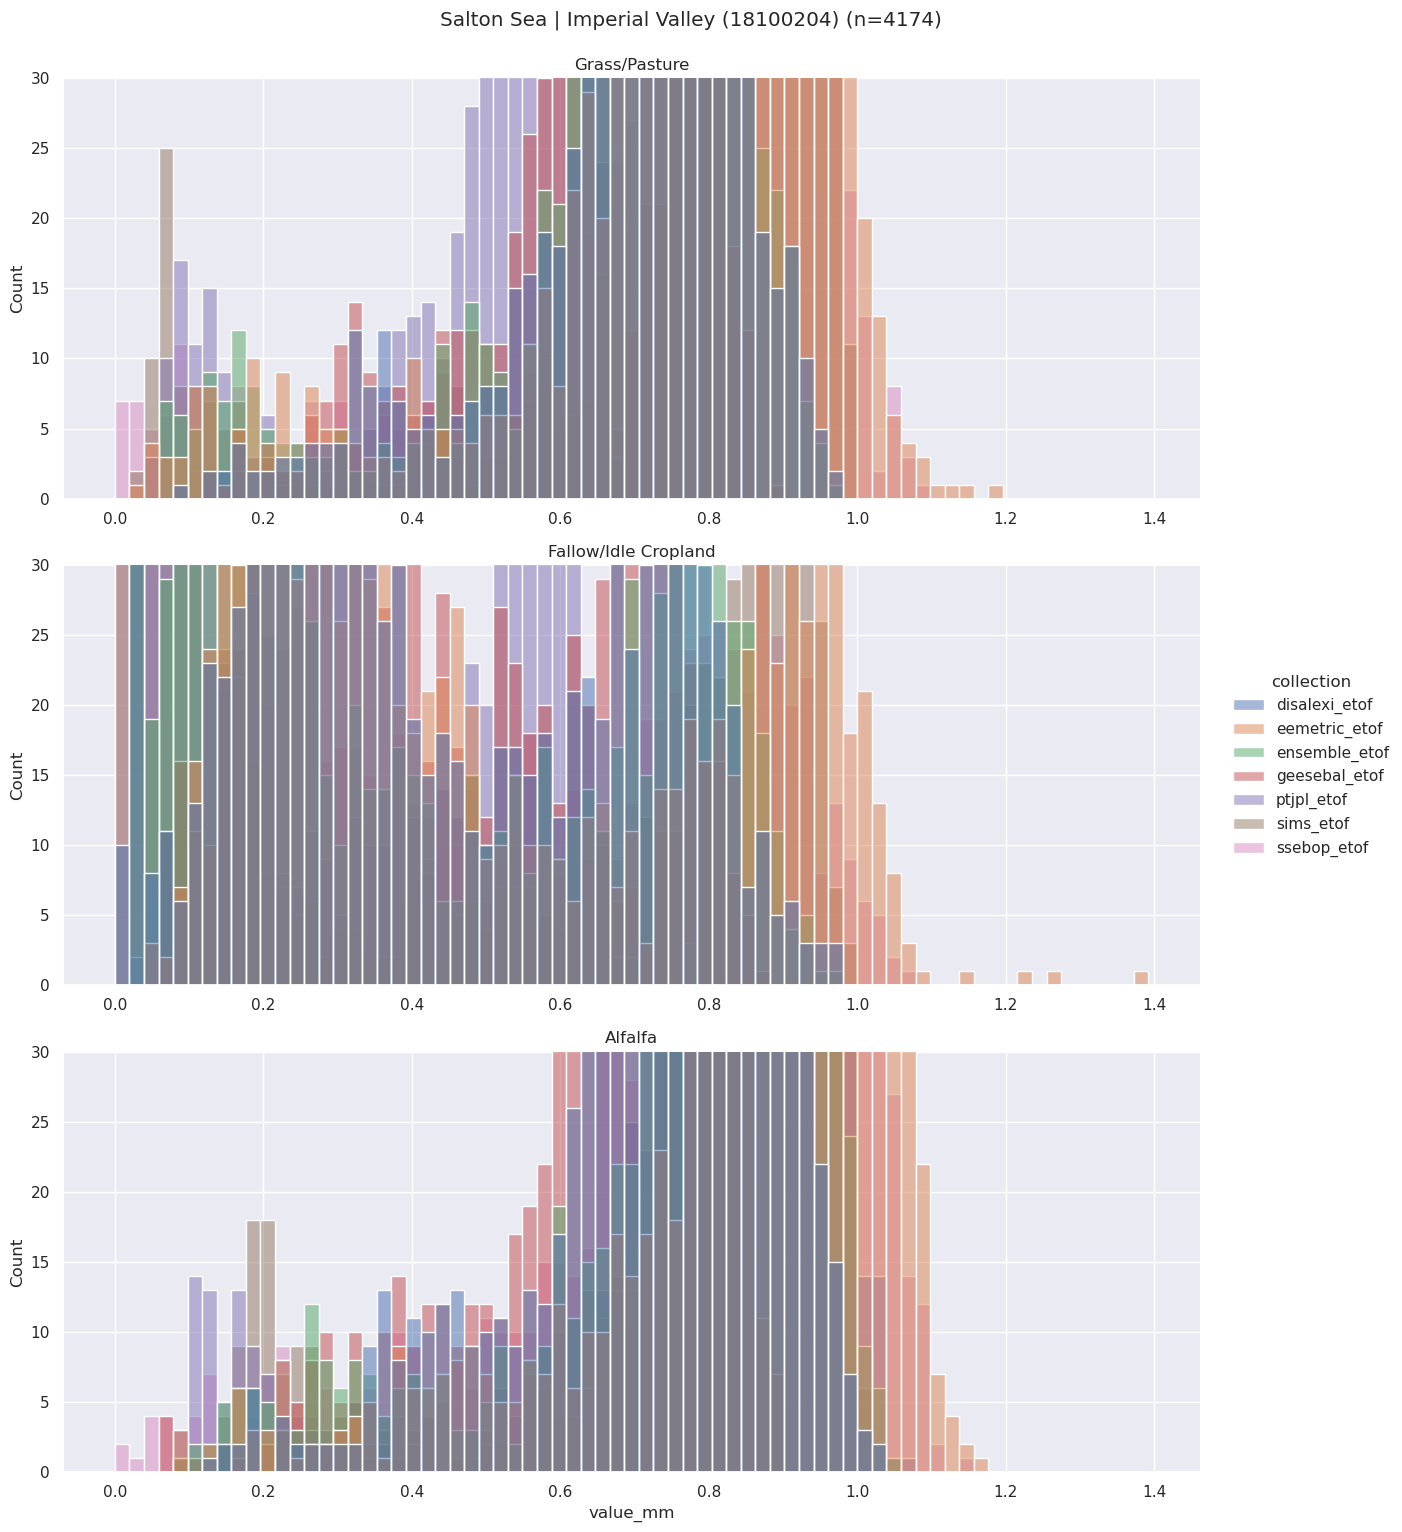

In [153]:
dis = sns.displot(ssiv_summer_maxes, x='value_mm', row='Class_Names', hue='collection',
                  aspect=2.5, facet_kws={'sharex': False, 'sharey': False});

for ax in dis.axes.flat:
    ax.set_ylim(0, 30)

dis.set_titles(row_template="{row_name}");
plt.suptitle("Salton Sea | Imperial Valley (18100204)" + f" (n={ssiv_summer_maxes['field_id'].nunique()})", y=1.02);
dis.savefig("../images/huc8/Salton Sea Imperial Valley.png")

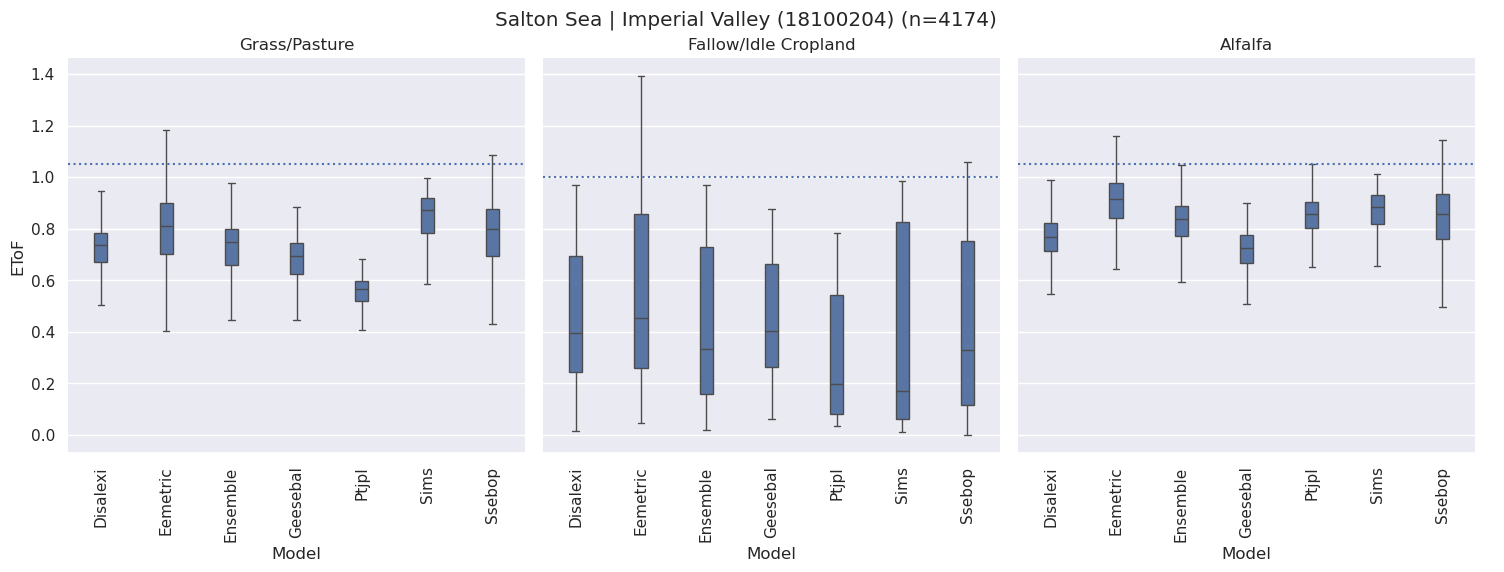

In [199]:
g = sns.catplot(ssiv_summer_maxes, kind='box', x='collection', y='value_mm', col='Class_Names', 
                estimator='mean', errorbar=('sd', 1),
                formatter=lambda x: x.split('_')[0].capitalize(),
                showfliers=False, width=0.2);

for (row, col, hue), data in g.facet_data():
    kcp_val = kcp[kcp['crop'] == data['Class_Names'].unique()[0]].kcp.values[0]
    ax = g.facet_axis(row, col)
    ax.axhline(y=kcp_val, linestyle='dotted')

g.set_ylabels("EToF")
g.set_xlabels("Model")
g.despine(left=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}");
g.tick_params(axis='x', rotation=90);
plt.suptitle("Salton Sea | Imperial Valley (18100204)" + f" (n={ssiv_summer_maxes['field_id'].nunique()})", y=1.02);

## Upper Tule | Central Valley (18030006)

In [156]:
utcv_metadata = pd.read_csv("../data/huc8/18030006_metadata.csv", low_memory=False, index_col=0)[['field_id', 'crop_2022', 'hectares']]
utcv_metadata.set_index('field_id', inplace=True)

In [159]:
utcv_etofs = pd.read_csv("../data/huc8/18030006_values.csv", low_memory=False, index_col=0)
utcv_etofs['time'] = pd.to_datetime(utcv_etofs['time'])
utcv_etofs.set_index('field_id', inplace=True)
utcv_etofs = utcv_etofs.join(utcv_metadata, on='field_id', how='left', validate='many_to_one')
utcv_etofs = utcv_etofs.join(cdl_names, on='crop_2022')

In [160]:
utcv_time_mask = (utcv_etofs['time'].dt.month >= visual_month_start) & (utcv_etofs['time'].dt.month <= visual_month_end)
utcv_summer_maxes = utcv_etofs[utcv_time_mask].groupby(['field_id', 'collection', 'crop_2022', 'Class_Names', 'hectares'])['value_mm'].agg('max')
utcv_summer_maxes = utcv_summer_maxes.reset_index()

In [161]:
utcv_summer_maxes.groupby(['Class_Names', 'collection'])['value_mm'].describe().round(2)[['mean', 'std']]

mean   std
Class_Names            collection               
Citrus                 disalexi_etof  0.79  0.20
                       eemetric_etof  0.68  0.13
                       ensemble_etof  0.69  0.12
                       geesebal_etof  0.74  0.11
                       ptjpl_etof     0.70  0.12
                       sims_etof      0.65  0.12
                       ssebop_etof    0.64  0.14
Dbl Crop Corn/Soybeans disalexi_etof  1.00  0.25
                       eemetric_etof  0.99  0.18
                       ensemble_etof  0.90  0.17
                       geesebal_etof  0.95  0.13
                       ptjpl_etof     0.81  0.14
                       sims_etof      0.89  0.16
                       ssebop_etof    0.92  0.25
Fallow/Idle Cropland   disalexi_etof  0.48  0.20
                       eemetric_etof  0.59  0.16
                       ensemble_etof  0.49  0.16
                       geesebal_etof  0.60  0.16
                       ptjpl_etof     0.47  0.11
                       sims_etof      0.42  0.19
                       ssebop_etof    0.42  0.19

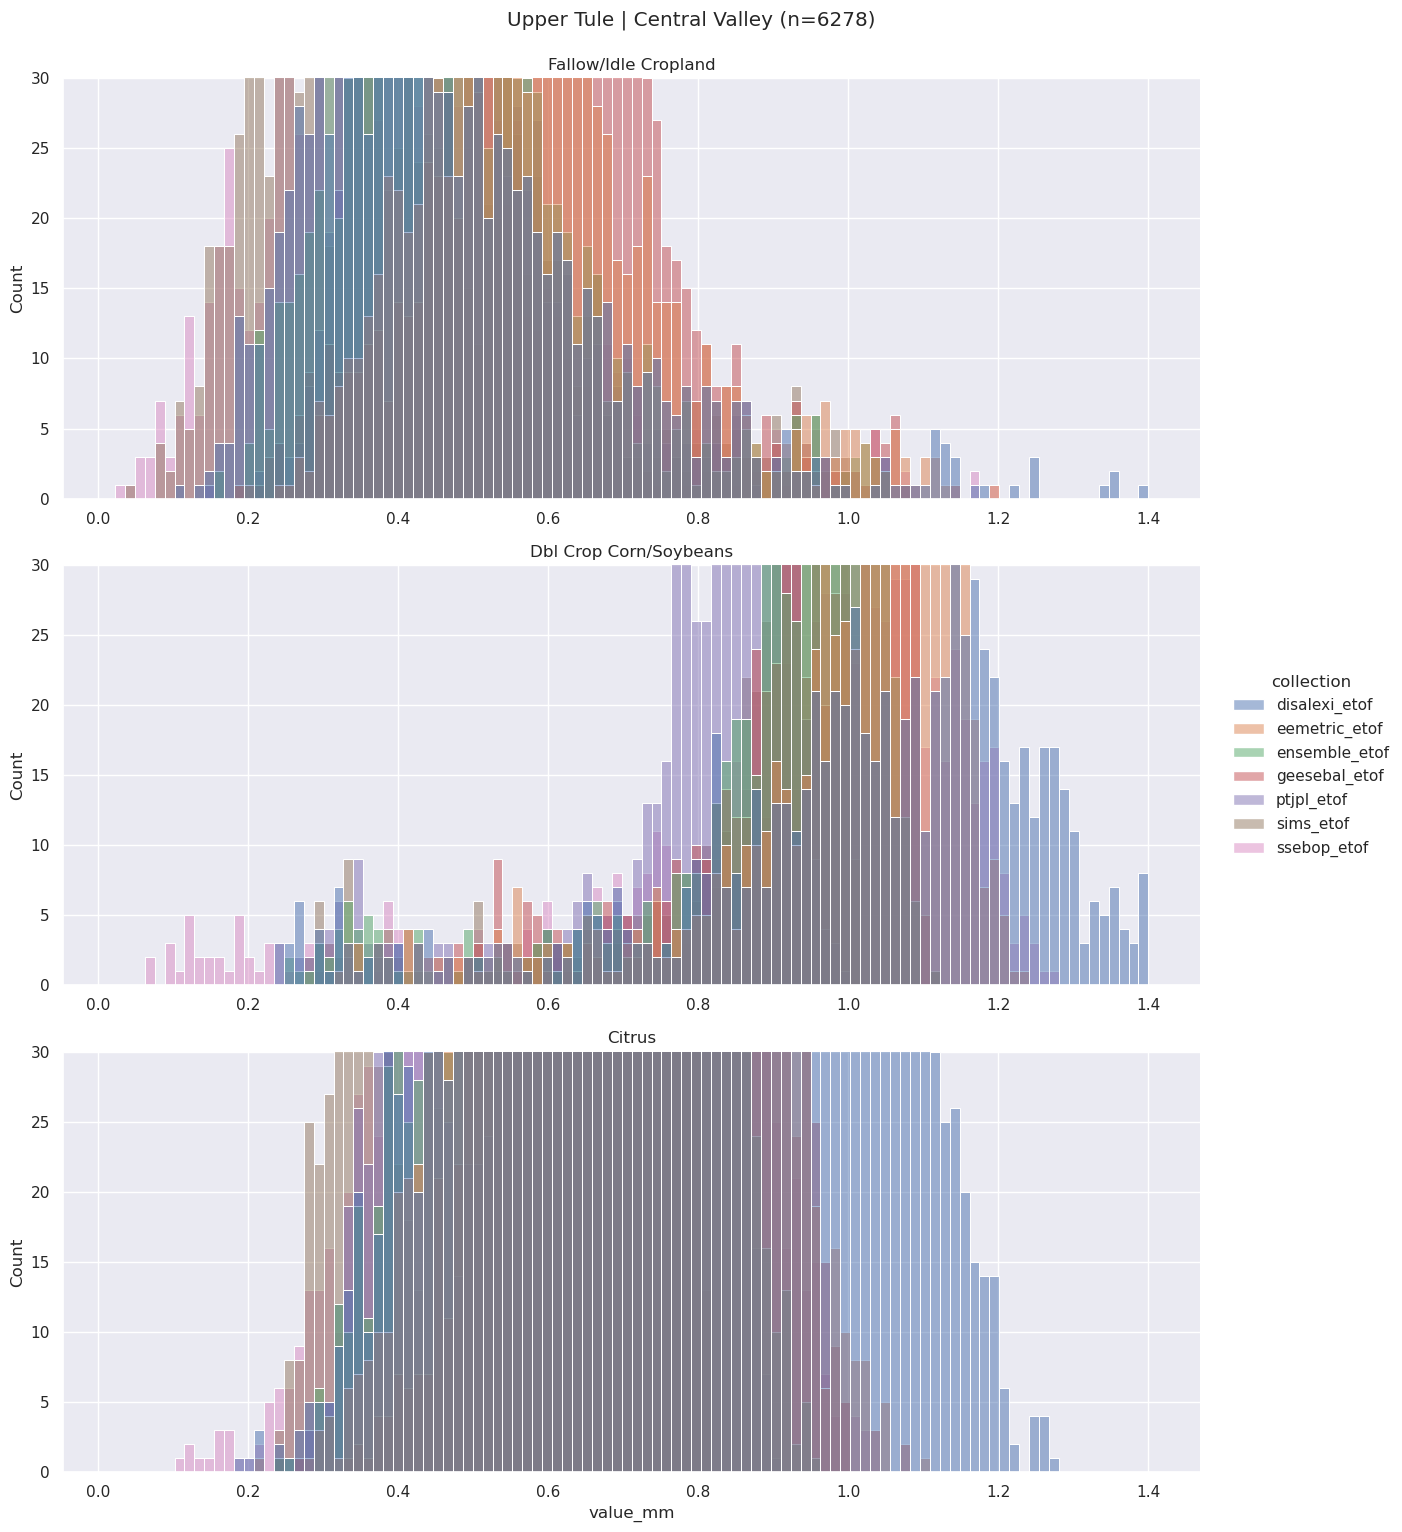

In [162]:
dis = sns.displot(utcv_summer_maxes, x='value_mm', row='Class_Names', hue='collection',
                  aspect=2.5, facet_kws={'sharex': False, 'sharey': False});

for ax in dis.axes.flat:
    ax.set_ylim(0, 30)

dis.set_titles(row_template="{row_name}");
plt.suptitle("Upper Tule | Central Valley" + f" (n={utcv_summer_maxes['field_id'].nunique()})", y=1.02);
dis.savefig("../images/huc8/Upper Tule Central Valley.png")

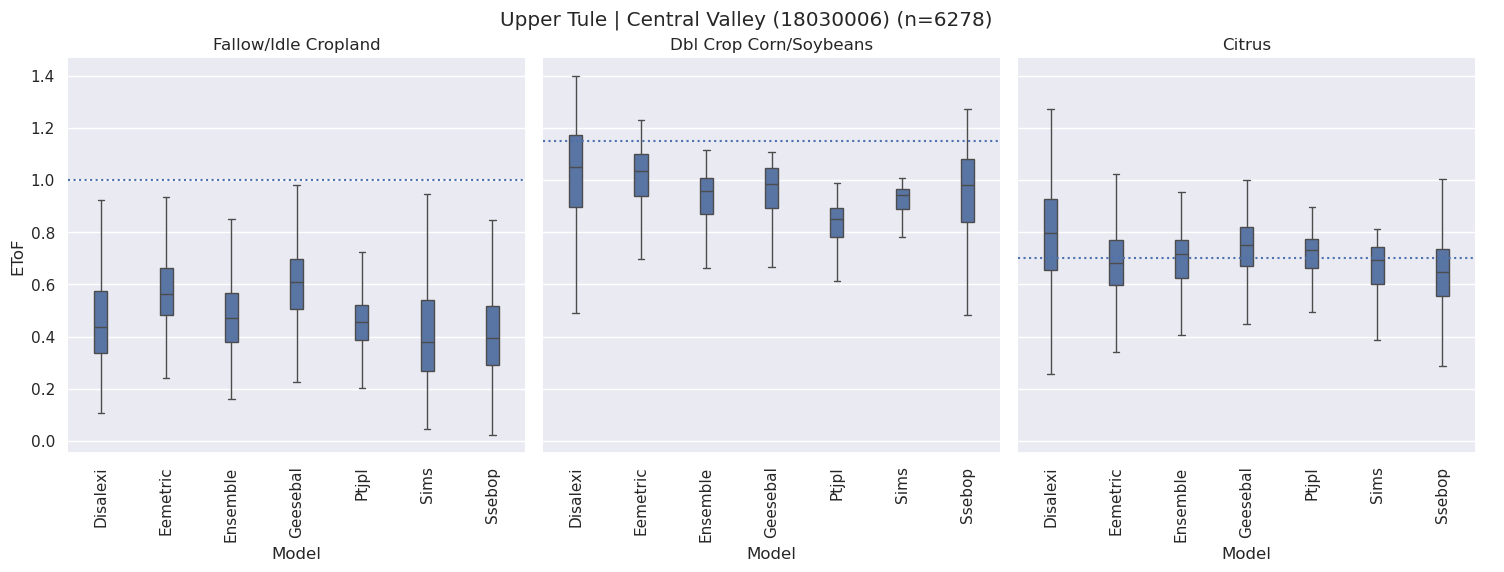

In [200]:
g = sns.catplot(utcv_summer_maxes, kind='box', x='collection', y='value_mm', col='Class_Names', 
                estimator='mean', errorbar=('sd', 1),
                formatter=lambda x: x.split('_')[0].capitalize(),
                showfliers=False, width=0.2);

for (row, col, hue), data in g.facet_data():
    kcp_val = kcp[kcp['crop'] == data['Class_Names'].unique()[0]].kcp.values[0]
    ax = g.facet_axis(row, col)
    ax.axhline(y=kcp_val, linestyle='dotted')

g.set_ylabels("EToF")
g.set_xlabels("Model")
g.despine(left=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}");
g.tick_params(axis='x', rotation=90);
plt.suptitle("Upper Tule | Central Valley (18030006)" + f" (n={utcv_summer_maxes['field_id'].nunique()})", y=1.02);

## San Joaquin Delta (18040003)

In [165]:
sjd_metadata = pd.read_csv("../data/huc8/18040003_metadata.csv", low_memory=False, index_col=0)[['field_id', 'crop_2022', 'hectares']]
sjd_metadata.set_index('field_id', inplace=True)

In [167]:
sjd_etofs = pd.read_csv("../data/huc8/18040003_values.csv", low_memory=False, index_col=0)
sjd_etofs['time'] = pd.to_datetime(sjd_etofs['time'])
sjd_etofs.set_index('field_id', inplace=True)
sjd_etofs = sjd_etofs.join(sjd_metadata, on='field_id', how='left', validate='many_to_one')
sjd_etofs = sjd_etofs.join(cdl_names, on='crop_2022')

In [169]:
sjd_time_mask = (sjd_etofs['time'].dt.month >= visual_month_start) & (sjd_etofs['time'].dt.month <= visual_month_end)
sjd_summer_maxes = sjd_etofs[sjd_time_mask].groupby(['field_id', 'collection', 'crop_2022', 'Class_Names', 'hectares'])['value_mm'].agg('max')
sjd_summer_maxes = sjd_summer_maxes.reset_index()

In [170]:
sjd_summer_maxes.groupby(['Class_Names', 'collection'])['value_mm'].describe().round(2)[['mean', 'std']]

mean   std
Class_Names            collection               
Almonds                disalexi_etof  0.83  0.18
                       eemetric_etof  0.70  0.18
                       ensemble_etof  0.78  0.16
                       geesebal_etof  0.72  0.18
                       ptjpl_etof     0.85  0.13
                       sims_etof      0.83  0.14
                       ssebop_etof    0.82  0.21
Dbl Crop Corn/Soybeans disalexi_etof  0.82  0.16
                       eemetric_etof  0.91  0.18
                       ensemble_etof  0.84  0.15
                       geesebal_etof  0.71  0.15
                       ptjpl_etof     0.82  0.11
                       sims_etof      0.90  0.14
                       ssebop_etof    0.92  0.22
Grapes                 disalexi_etof  0.50  0.12
                       eemetric_etof  0.46  0.14
                       ensemble_etof  0.50  0.12
                       geesebal_etof  0.45  0.16
                       ptjpl_etof     0.67  0.09
                       sims_etof      0.59  0.09
                       ssebop_etof    0.56  0.18

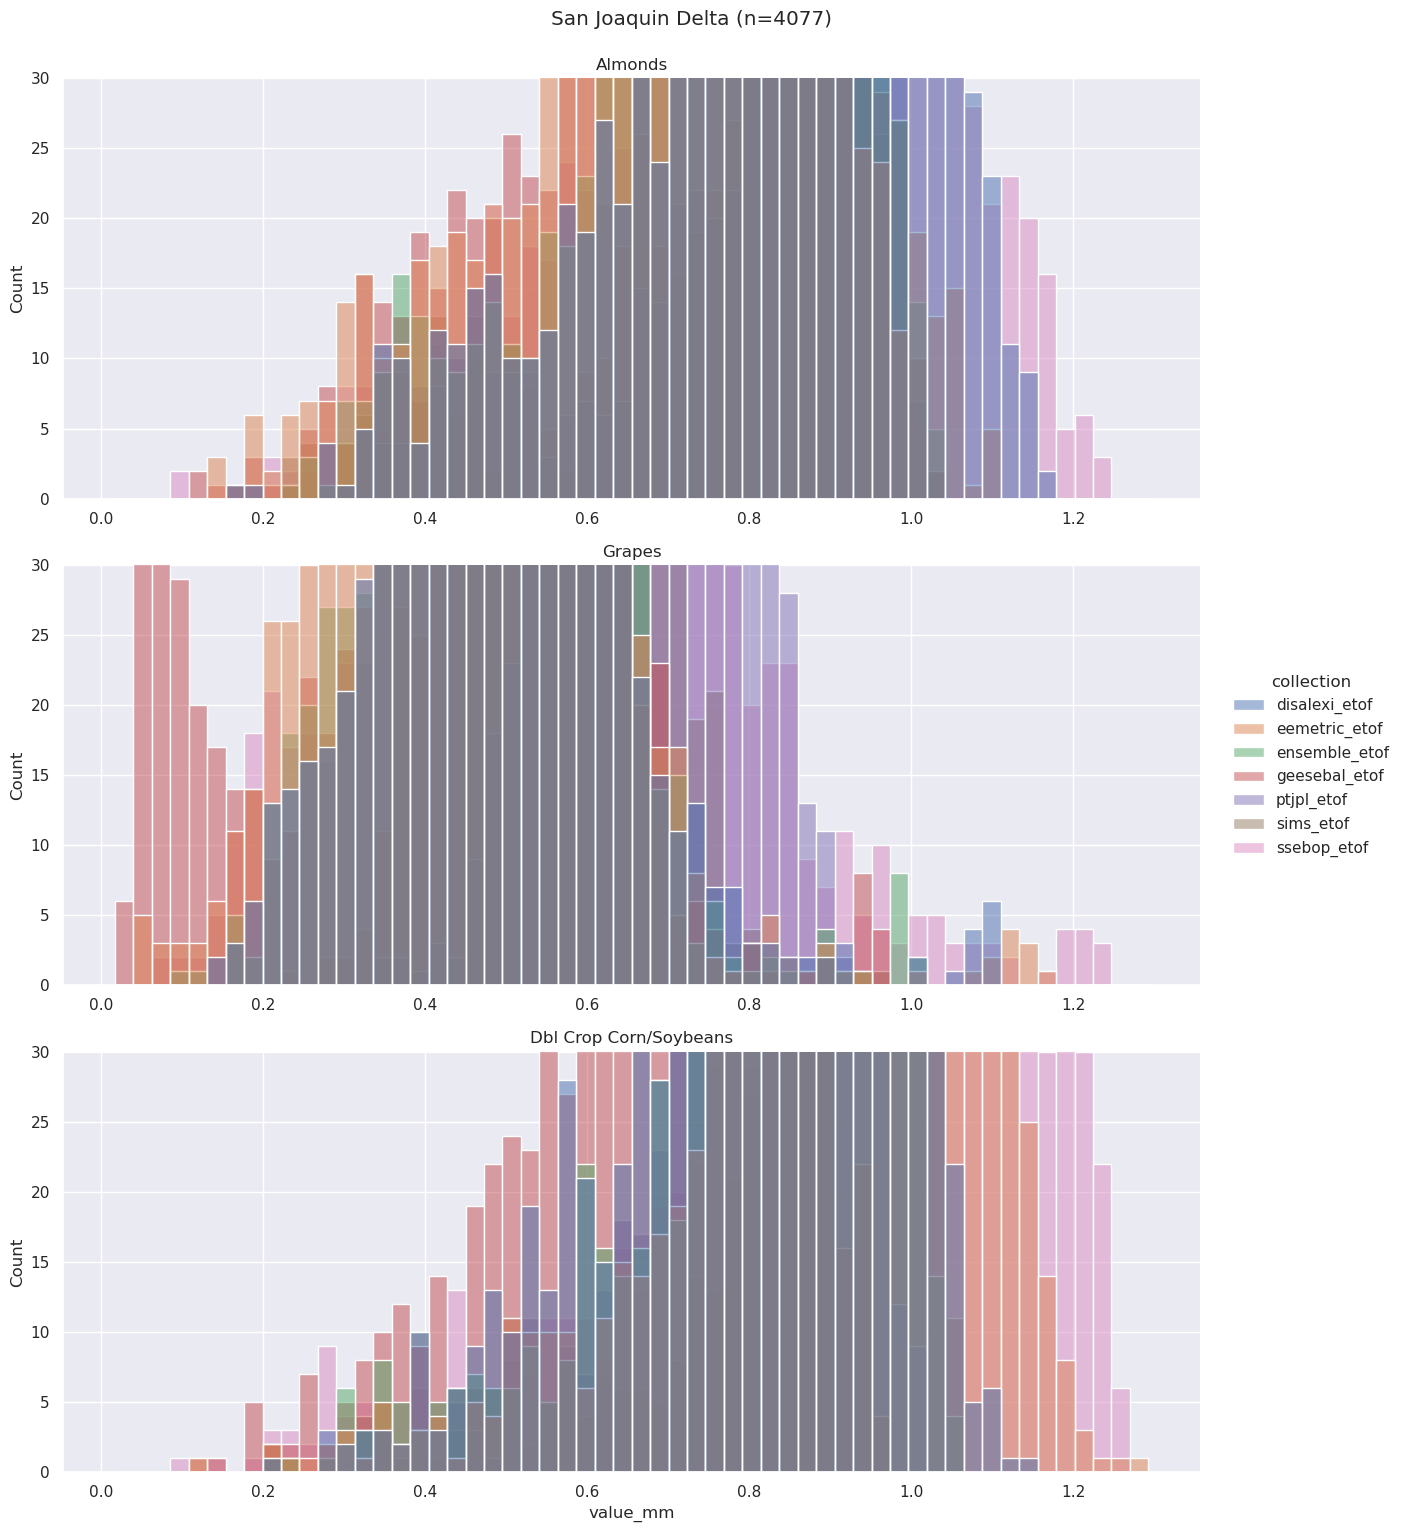

In [171]:
dis = sns.displot(sjd_summer_maxes, x='value_mm', row='Class_Names', hue='collection',
                  aspect=2.5, facet_kws={'sharex': False, 'sharey': False});

for ax in dis.axes.flat:
    ax.set_ylim(0, 30)

dis.set_titles(row_template="{row_name}");
plt.suptitle("San Joaquin Delta" + f" (n={sjd_summer_maxes['field_id'].nunique()})", y=1.02);
dis.savefig("../images/huc8/San Joaquin Delta.png")

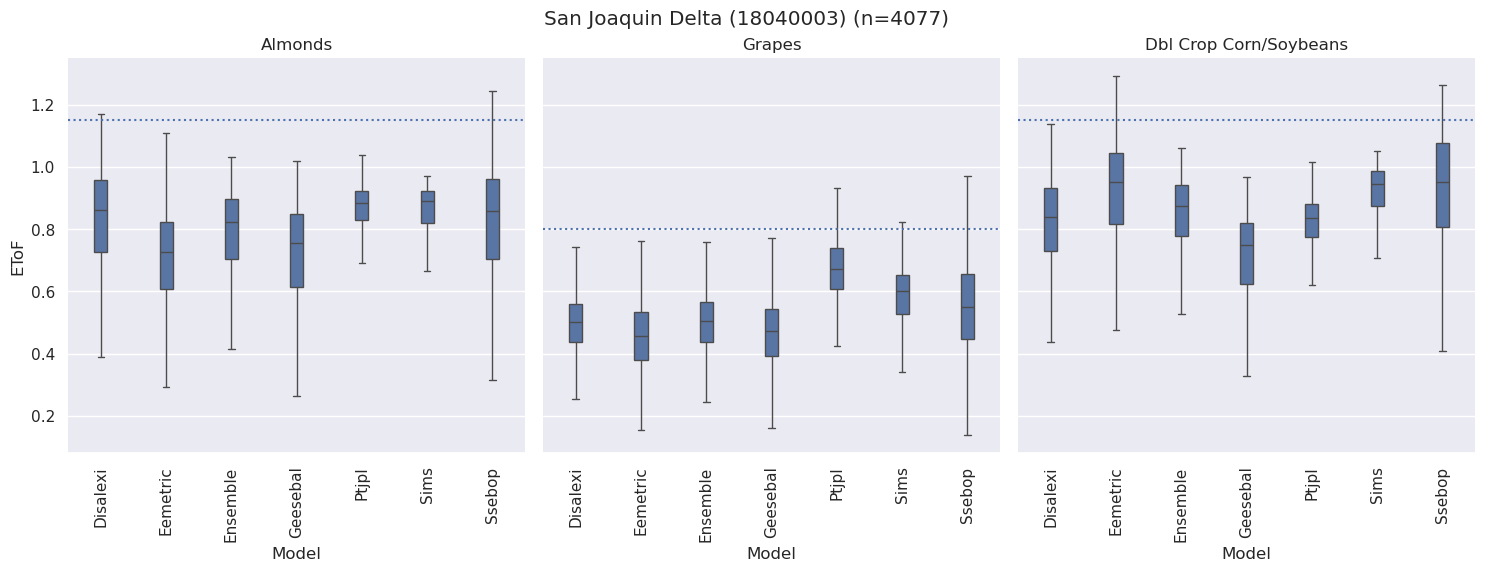

In [201]:
g = sns.catplot(sjd_summer_maxes, kind='box', x='collection', y='value_mm', col='Class_Names', 
                estimator='mean', errorbar=('sd', 1),
                formatter=lambda x: x.split('_')[0].capitalize(),
                showfliers=False, width=0.2);

for (row, col, hue), data in g.facet_data():
    kcp_val = kcp[kcp['crop'] == data['Class_Names'].unique()[0]].kcp.values[0]
    ax = g.facet_axis(row, col)
    ax.axhline(y=kcp_val, linestyle='dotted')

g.set_ylabels("EToF")
g.set_xlabels("Model")
g.despine(left=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}");
g.tick_params(axis='x', rotation=90);
plt.suptitle("San Joaquin Delta (18040003)" + f" (n={sjd_summer_maxes['field_id'].nunique()})", y=1.02);

## Sacramento-Stone: Colusa Sub-basin (18020104)

In [173]:
sscs_metadata = pd.read_csv("../data/huc8/18020104_metadata.csv", low_memory=False, index_col=0)[['field_id', 'crop_2022', 'hectares']]
sscs_metadata.set_index('field_id', inplace=True)

In [175]:
sscs_etofs = pd.read_csv("../data/huc8/18020104_values.csv", low_memory=False, index_col=0)
sscs_etofs['time'] = pd.to_datetime(sscs_etofs['time'])
sscs_etofs.set_index('field_id', inplace=True)
sscs_etofs = sscs_etofs.join(sscs_metadata, on='field_id', how='left', validate='many_to_one')
sscs_etofs = sscs_etofs.join(cdl_names, on='crop_2022')

In [177]:
sscs_time_mask = (sscs_etofs['time'].dt.month >= visual_month_start) & (sscs_etofs['time'].dt.month <= visual_month_end)
sscs_summer_maxes = sscs_etofs[sscs_time_mask].groupby(['field_id', 'collection', 'crop_2022', 'Class_Names', 'hectares'])['value_mm'].agg('max')
sscs_summer_maxes = sscs_summer_maxes.reset_index()

In [203]:
sscs_summer_maxes.groupby(['Class_Names', 'collection'])['value_mm'].describe().round(2)[['mean', 'std', 'max']]

mean   std   max
Class_Names collection                     
Almonds     disalexi_etof  0.73  0.19  1.40
            eemetric_etof  0.61  0.20  1.12
            ensemble_etof  0.74  0.19  1.03
            geesebal_etof  0.63  0.20  1.06
            ptjpl_etof     0.85  0.17  1.07
            sims_etof      0.83  0.18  0.97
            ssebop_etof    0.83  0.22  1.24
Rice        disalexi_etof  0.39  0.21  1.23
            eemetric_etof  0.44  0.26  1.28
            ensemble_etof  0.40  0.23  1.06
            geesebal_etof  0.29  0.25  1.01
            ptjpl_etof     0.53  0.19  1.09
            sims_etof      0.53  0.22  1.05
            ssebop_etof    0.39  0.30  1.27
Walnuts     disalexi_etof  0.74  0.16  1.29
            eemetric_etof  0.72  0.20  1.13
            ensemble_etof  0.79  0.15  1.04
            geesebal_etof  0.73  0.16  1.06
            ptjpl_etof     0.87  0.12  1.07
            sims_etof      0.96  0.12  1.06
            ssebop_etof    0.88  0.19  1.21

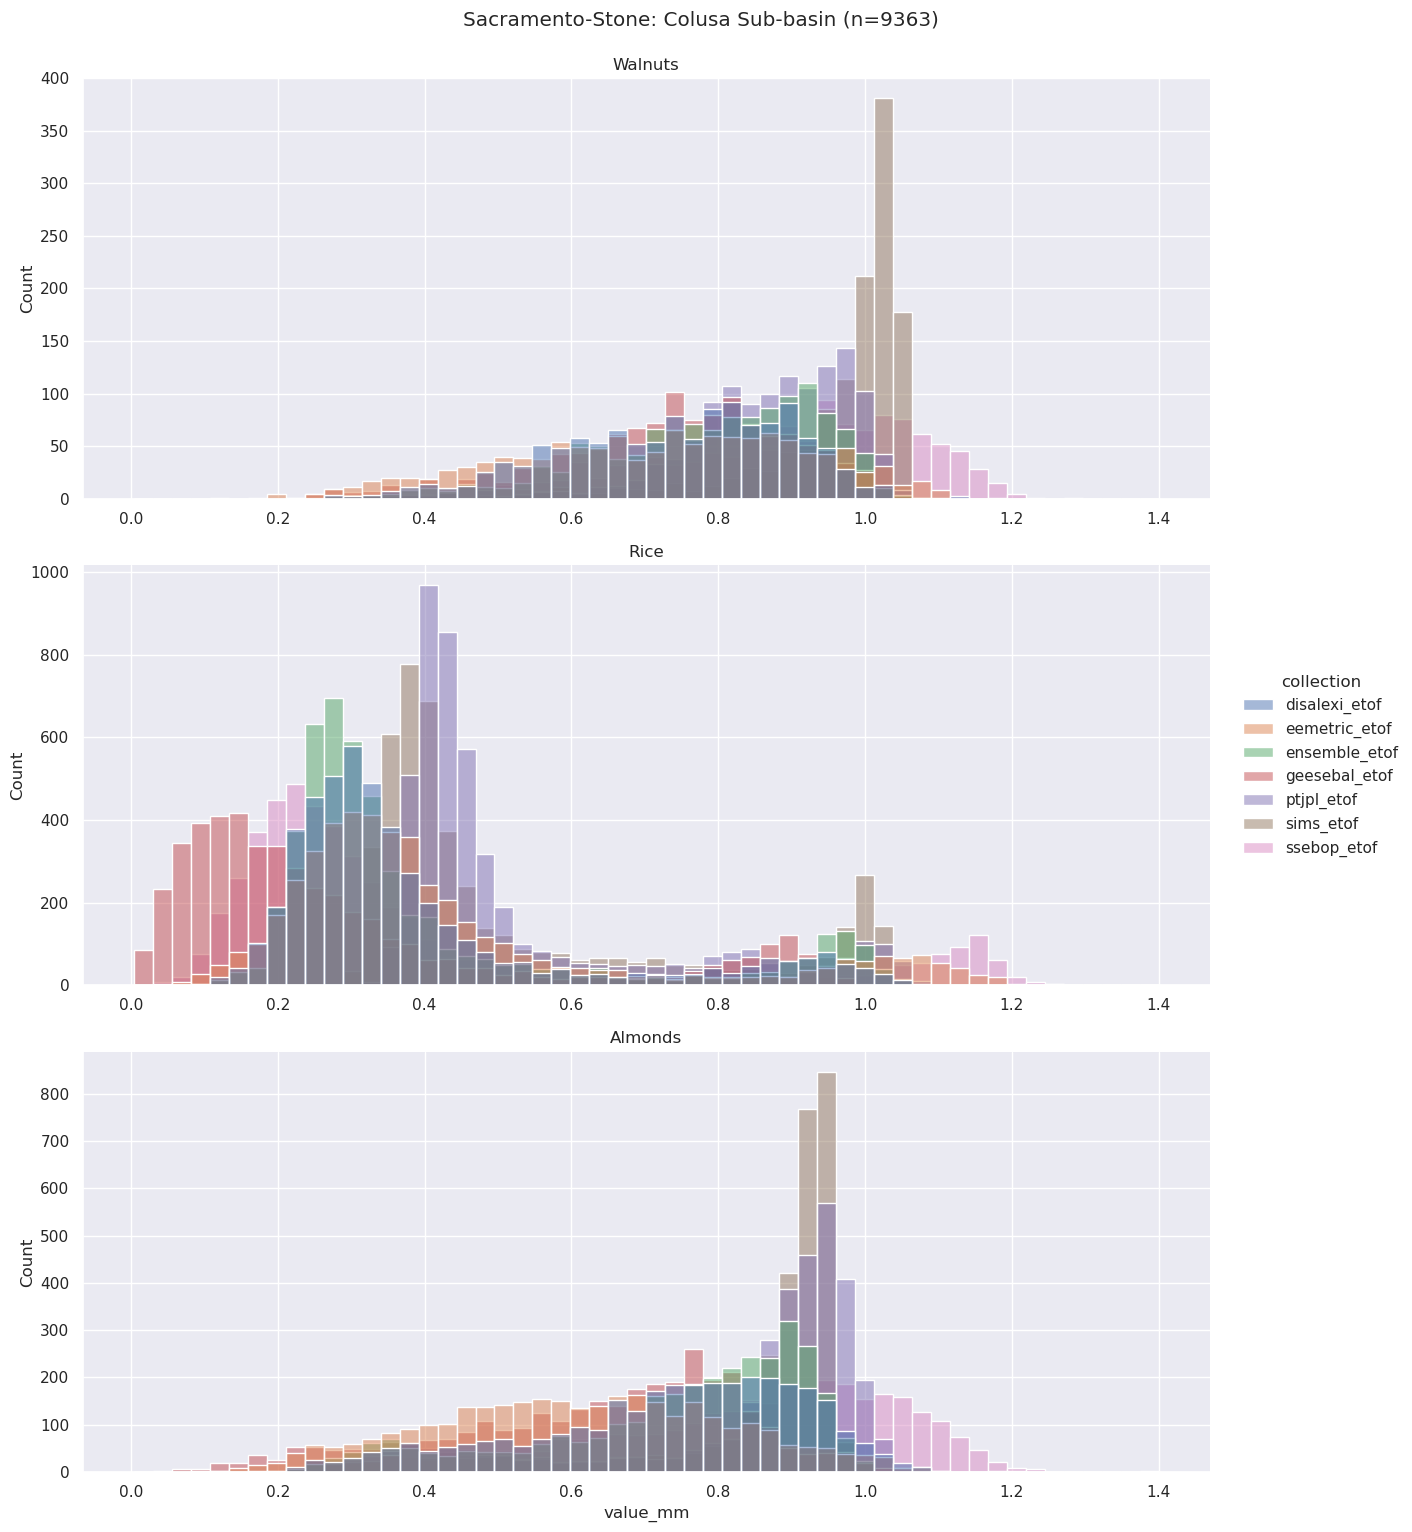

In [179]:
dis = sns.displot(sscs_summer_maxes, x='value_mm', row='Class_Names', hue='collection',
                  aspect=2.5, facet_kws={'sharex': False, 'sharey': False});

dis.set_titles(row_template="{row_name}");
plt.suptitle("Sacramento-Stone: Colusa Sub-basin" + f" (n={sscs_summer_maxes['field_id'].nunique()})", y=1.02);
dis.savefig("../images/huc8/Sacramento-Stone Colusa Sub-basin.png")

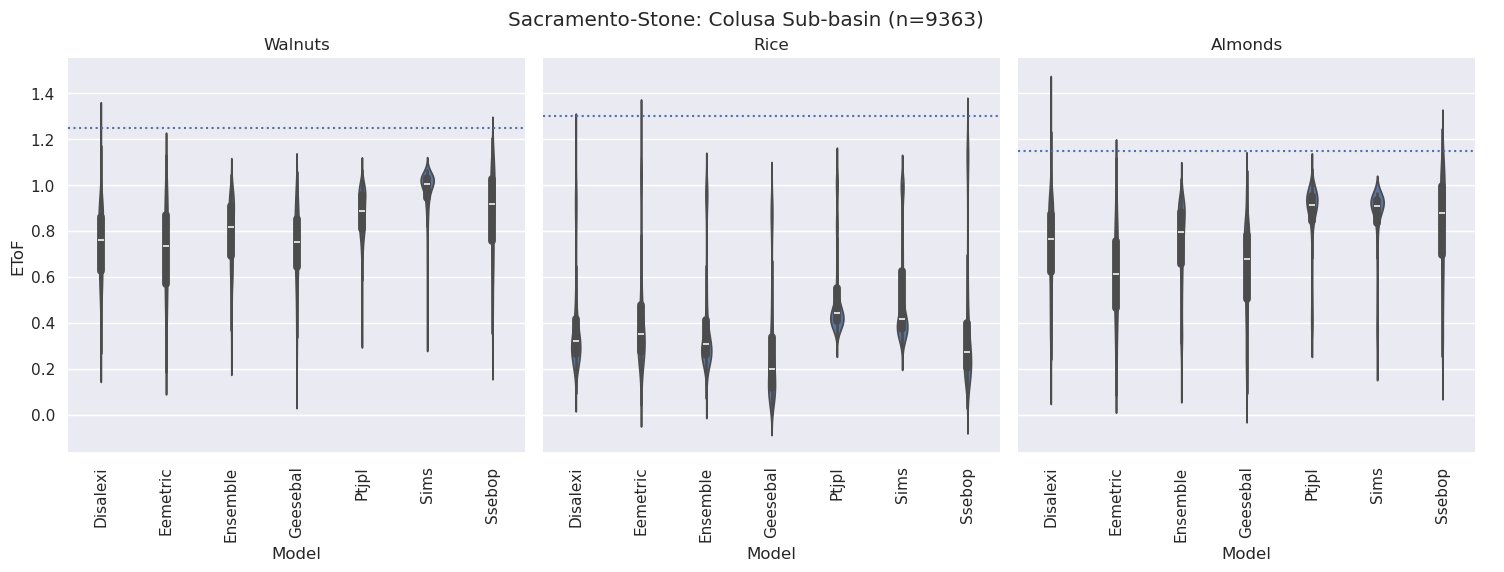

In [211]:
g = sns.catplot(sscs_summer_maxes, kind='violin', x='collection', y='value_mm', col='Class_Names', 
                estimator='mean', errorbar=('sd', 1),
                formatter=lambda x: x.split('_')[0].capitalize(),
                # showfliers=False, 
                width=0.2);

for (row, col, hue), data in g.facet_data():
    kcp_val = kcp[kcp['crop'] == data['Class_Names'].unique()[0]].kcp.values[0]
    ax = g.facet_axis(row, col)
    ax.axhline(y=kcp_val, linestyle='dotted')

g.set_ylabels("EToF")
g.set_xlabels("Model")
g.despine(left=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}");
g.tick_params(axis='x', rotation=90);
plt.suptitle("Sacramento-Stone: Colusa Sub-basin" + f" (n={sscs_summer_maxes['field_id'].nunique()})", y=1.02);

In [220]:
kcp_lookup = pd.read_csv("https://raw.githubusercontent.com/aetriusgx/openet/refs/heads/main/data/1993%20NEH%20Kcp.csv",
                        index_col="cdl_code", na_values={'kcp': -9999})[['kcp']]
kcp_lookup

,kcp
cdl_code,
36,1.15
75,1.15
68,1.25
223,1.15
92,NaN
...,...
203,NaN
251,NaN
252,NaN


In [221]:
sscs_summer_maxes.join(kcp_lookup, on='crop_2022')

,field_id,collection,crop_2022,Class_Names,hectares,value_mm,kcp
0,6138756,disalexi_etof,76,Walnuts,2.509,0.650,1.25
1,6138756,eemetric_etof,76,Walnuts,2.509,0.478,1.25
2,6138756,ensemble_etof,76,Walnuts,2.509,0.667,1.25
3,6138756,geesebal_etof,76,Walnuts,2.509,0.654,1.25
4,6138756,ptjpl_etof,76,Walnuts,2.509,0.802,1.25
...,...,...,...,...,...,...,...
65536,6244589,ensemble_etof,75,Almonds,331.853,0.764,1.15
65537,6244589,geesebal_etof,75,Almonds,331.853,0.550,1.15
65538,6244589,ptjpl_etof,75,Almonds,331.853,0.887,1.15
65539,6244589,sims_etof,75,Almonds,331.853,0.920,1.15
